In [1]:
import sklearn

In [2]:
import os
import glob
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import lazypredict
import lightgbm as lgb
# from imblearn.over_sampling import SMOTE
#from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

# Utility functions

In [4]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [5]:
def apply_threshold_filter(perc, data):
    min_count =  int(((100-perc)/100)*data.shape[0] + 1)
    return data.dropna( axis=1, thresh=min_count)

In [6]:
def encoder(data):
    le=LabelEncoder()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col]=le.fit_transform(data[col].astype(str))
    return data

In [7]:
def filter_high_corr(data, corr):
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    data.drop(to_drop, axis=1, inplace=True)
    return data

In [8]:
def find_corelation(data):
    plt.figure(figsize=(40,40))
    data_corr=data.corr().abs()
    sns.heatmap(data_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
    plt.title('Correlation Heatmap')
    return data_corr

In [9]:
def train_test_pipeline(data):
    data = apply_threshold_filter(25, data)
    data =  encoder(data)
    data.fillna(0, inplace=True)
    corr = find_corelation(data)
    data = filter_high_corr(data, corr)
    return data

In [10]:
def calculate_mean(data):
    cols=data.groupby('SK_ID_CURR').count().columns
    func={i:'mean' for i in cols }
    return func

In [11]:
def extra_data_pipeline(data):
    data.drop(['SK_ID_PREV'], axis=1, inplace=True)
    data = apply_threshold_filter(25, data)
    func = calculate_mean(data)
    data = encoder(data)
    data_grouped=data.groupby('SK_ID_CURR').agg(func).transform(lambda x: x.fillna(x.mean()))
    corr = find_corelation(data_grouped)
    data_grouped = filter_high_corr(data_grouped, corr)
    return data_grouped
    

# Data

In [12]:
path = os.path.join(os.getcwd(), 'Data','*.csv')

In [13]:
files = glob.glob(path)
files

['C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\application.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\application_test.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\application_train.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\bureau.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\bureau_balance.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\credit_card_balance.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\df_application.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\HomeCredit_columns_description.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\installments_payments.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\\Case 7\\Data\\POS_CASH_balance.csv',
 'C:\\Users\\AJ ASUS\\Downloads\\open class room\\Cas 7\

In [14]:
application=pd.read_csv(files[0])
test_data=pd.read_csv(files[1])
train_data=pd.read_csv(files[2])
bureau=pd.read_csv(files[3])
BB=pd.read_csv(files[4])
CCB=pd.read_csv(files[5])
application=pd.read_csv(files[6])
description_df=pd.read_csv(files[7], encoding= 'unicode_escape')
IP=pd.read_csv(files[8])
POS_CASH=pd.read_csv(files[9])
PA=pd.read_csv(files[10])
#sAMPLE=pd.read_csv(files[11])

In [15]:
#extra ( ot used to find minignfull data there:sample_submission,HomeCredit_columns_description)

# bureau balance . bureau ===== not find anything 

# Understanding data

### Data description

In [16]:
#description_df=pd.read_csv(files[5], encoding= 'unicode_escape')
description_df

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

### Training Data

In [17]:
#train_data=pd.read_csv(files[1])
print('Training data shape: ', train_data.shape)
train_data

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

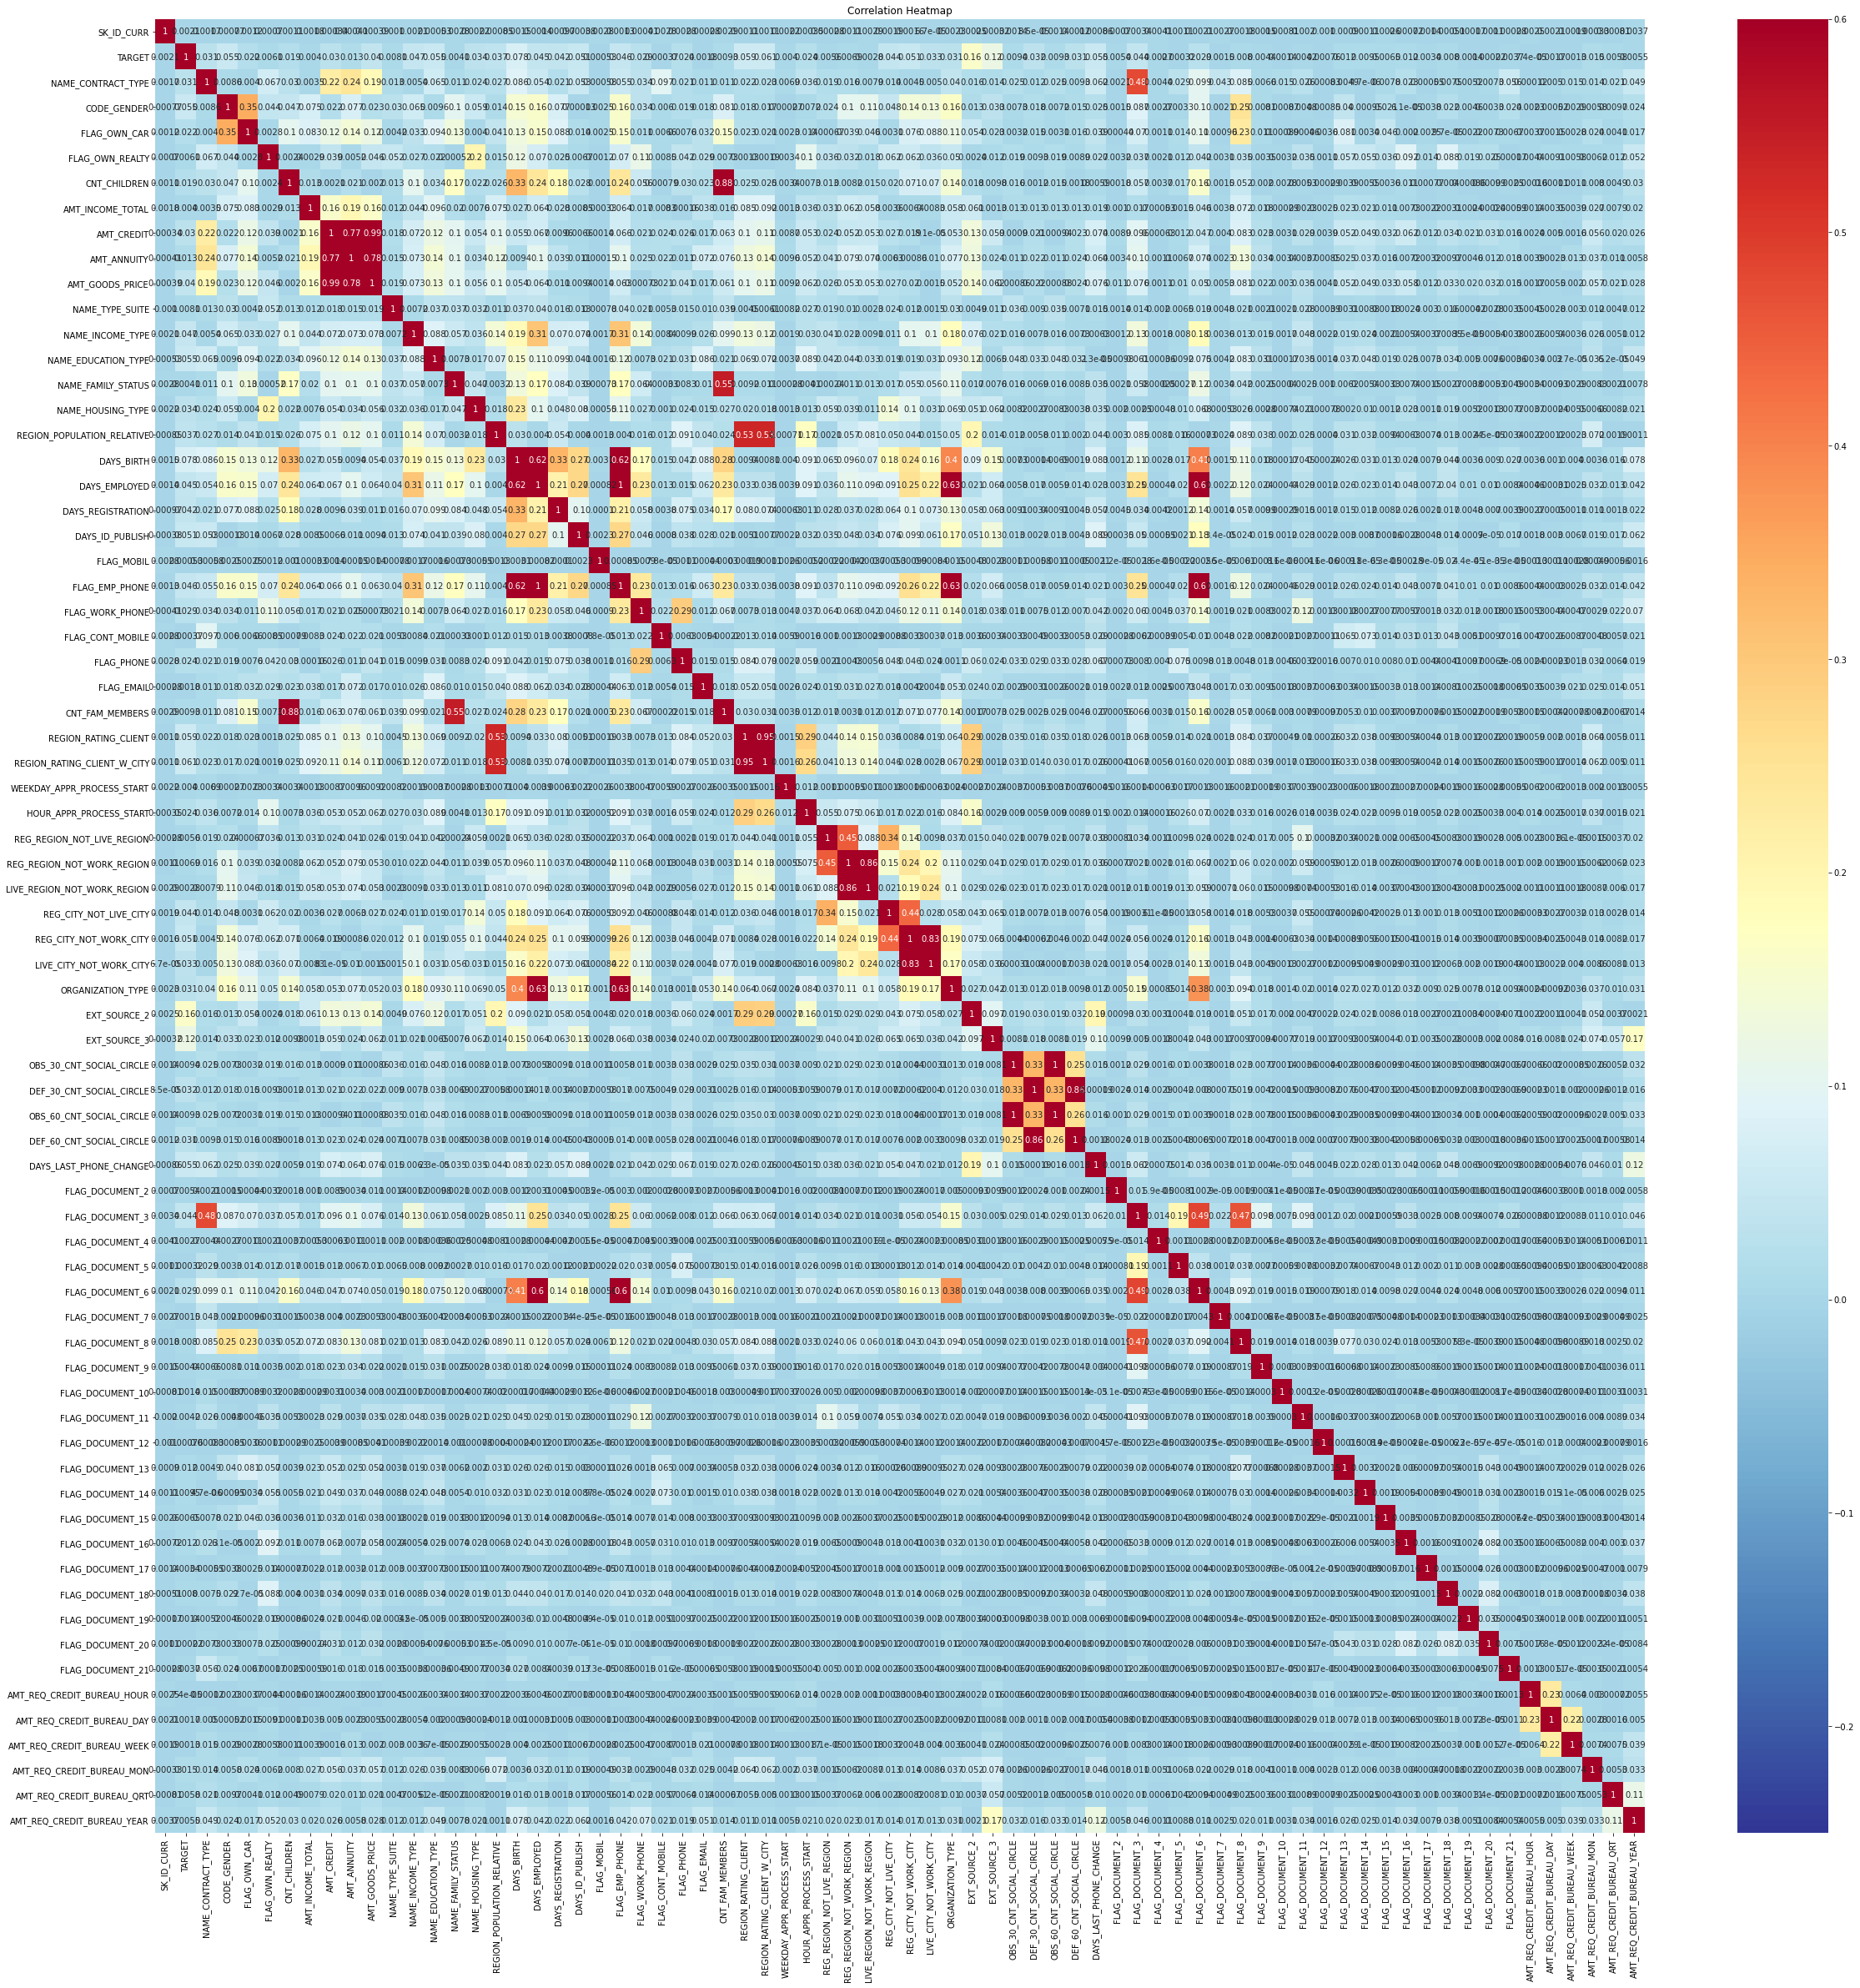

In [18]:
train_data = train_test_pipeline(train_data)

In [19]:
train_data

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0           100002       1                   0            1             0   
1           100003       0                   0            0             0   
2           100004       0                   1            1             1   
3           100006       0                   0            0             0   
4           100007       0                   0            1             0   
...            ...     ...                 ...          ...           ...   
307506      456251       0                   0            1             0   
307507      456252       0                   0            0             0   
307508      456253       0                   0            0             0   
307509      456254       1                   0            0             0   
307510      456255       0                   0            0             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     1             0          202500.0    406597.5   
1                     0             0          270000.0   1293502.5   
2                     1             0           67500.0    135000.0   
3                     1             0          135000.0    312682.5   
4                     1             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307506                0             0          157500.0    254700.0   
307507                1             0           72000.0    269550.0   
307508                1             0          153000.0    677664.0   
307509                1             0          171000.0    370107.0   
307510                0             0          157500.0    675000.0   

        AMT_ANNUITY  NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0           24700.5                6                 7                    4   
1           35698.5                1                 4                    1   
2            6750.0                6                 7                    4   
3           29686.5                6                 7                    4   
4           21865.5                6                 7                    4   
...             ...              ...               ...                  ...   
307506      27558.0                6                 7                    4   
307507      12001.5                6                 3                    4   
307508      29979.0                6                 7                    1   
307509      20205.0                6                 1                    4   
307510      49117.5                6                 1                    1   

        NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                        3                  1                    0.018801   
1                        1                  1                    0.003541   
2                        3                  1                    0.010032   
3                        0                  1                    0.008019   
4                        3                  1                    0.028663   
...                    ...                ...                         ...   
307506                   2                  5                    0.032561   
307507                   5                  1                    0.025164   
307508                   2                  1                    0.005002   
307509                   1                  1                    0.005313   
307510                   1                  1                    0.046220   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0            -9461           -637            -3648.0            -2120   
1           -16765          -1188            -1186.0             -291   
2           -19046           -225            -4260.0            -2531   
3           -19005          -3039            -9833.0            

### Testing Data

In [20]:
#test_data=pd.read_csv(files[0])
print('Testing data shape: ', test_data.shape)
test_data

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         Cash loans           F            N               Y   
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0             450000.0   Unaccompanied               Working   
1             180000.0   Unaccompanied               Working   
2             630000.0             NaN               Working   
3            1575000.0   Unaccompanied               Working   
4             625500.0   Unaccompanied               Working   
...                ...             ...                   ...   
48739         270000.0   Unaccompanied               Working   
48740         495000.0   Unaccompanied  Commercial associate   
48741         315000.0   Unaccompanied  Commercial associate   
48742         450000.0          Family  Commercial associate   
48743         270000.0   Unaccompanied               Working   

                 NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0                   Higher education            Married  House / apartment   
1      Secondary / secondary special            Married  House / apartment   
2                   Higher education            Married  House / apartment   
3      Secondary / secondary special            Married  House / apartment   
4      Secondary / secondary special            Married  House / apartment   
...                              ...                ...                ...   
48739  Secondary / secondary special              Widow  House / apartment   
48740  Secondary / secondary special            Married  House / apartment   
48741  Secondary / secondary special            Married  House / apartment   
48742               Higher education            Married  House / apartment   
48743  Secondary / secondary special            Married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                        0.018850      -19241          -2329   
1                        0.035792      -18064          -4469   
2                        0.019101      -20038          -4458   
3                        0.026392      -13976          -1866   
4                        0.010032      -13040          -2191   
...                           ...         ...            ...   
48739                    0.002042      -19970          -5169   
48740                  

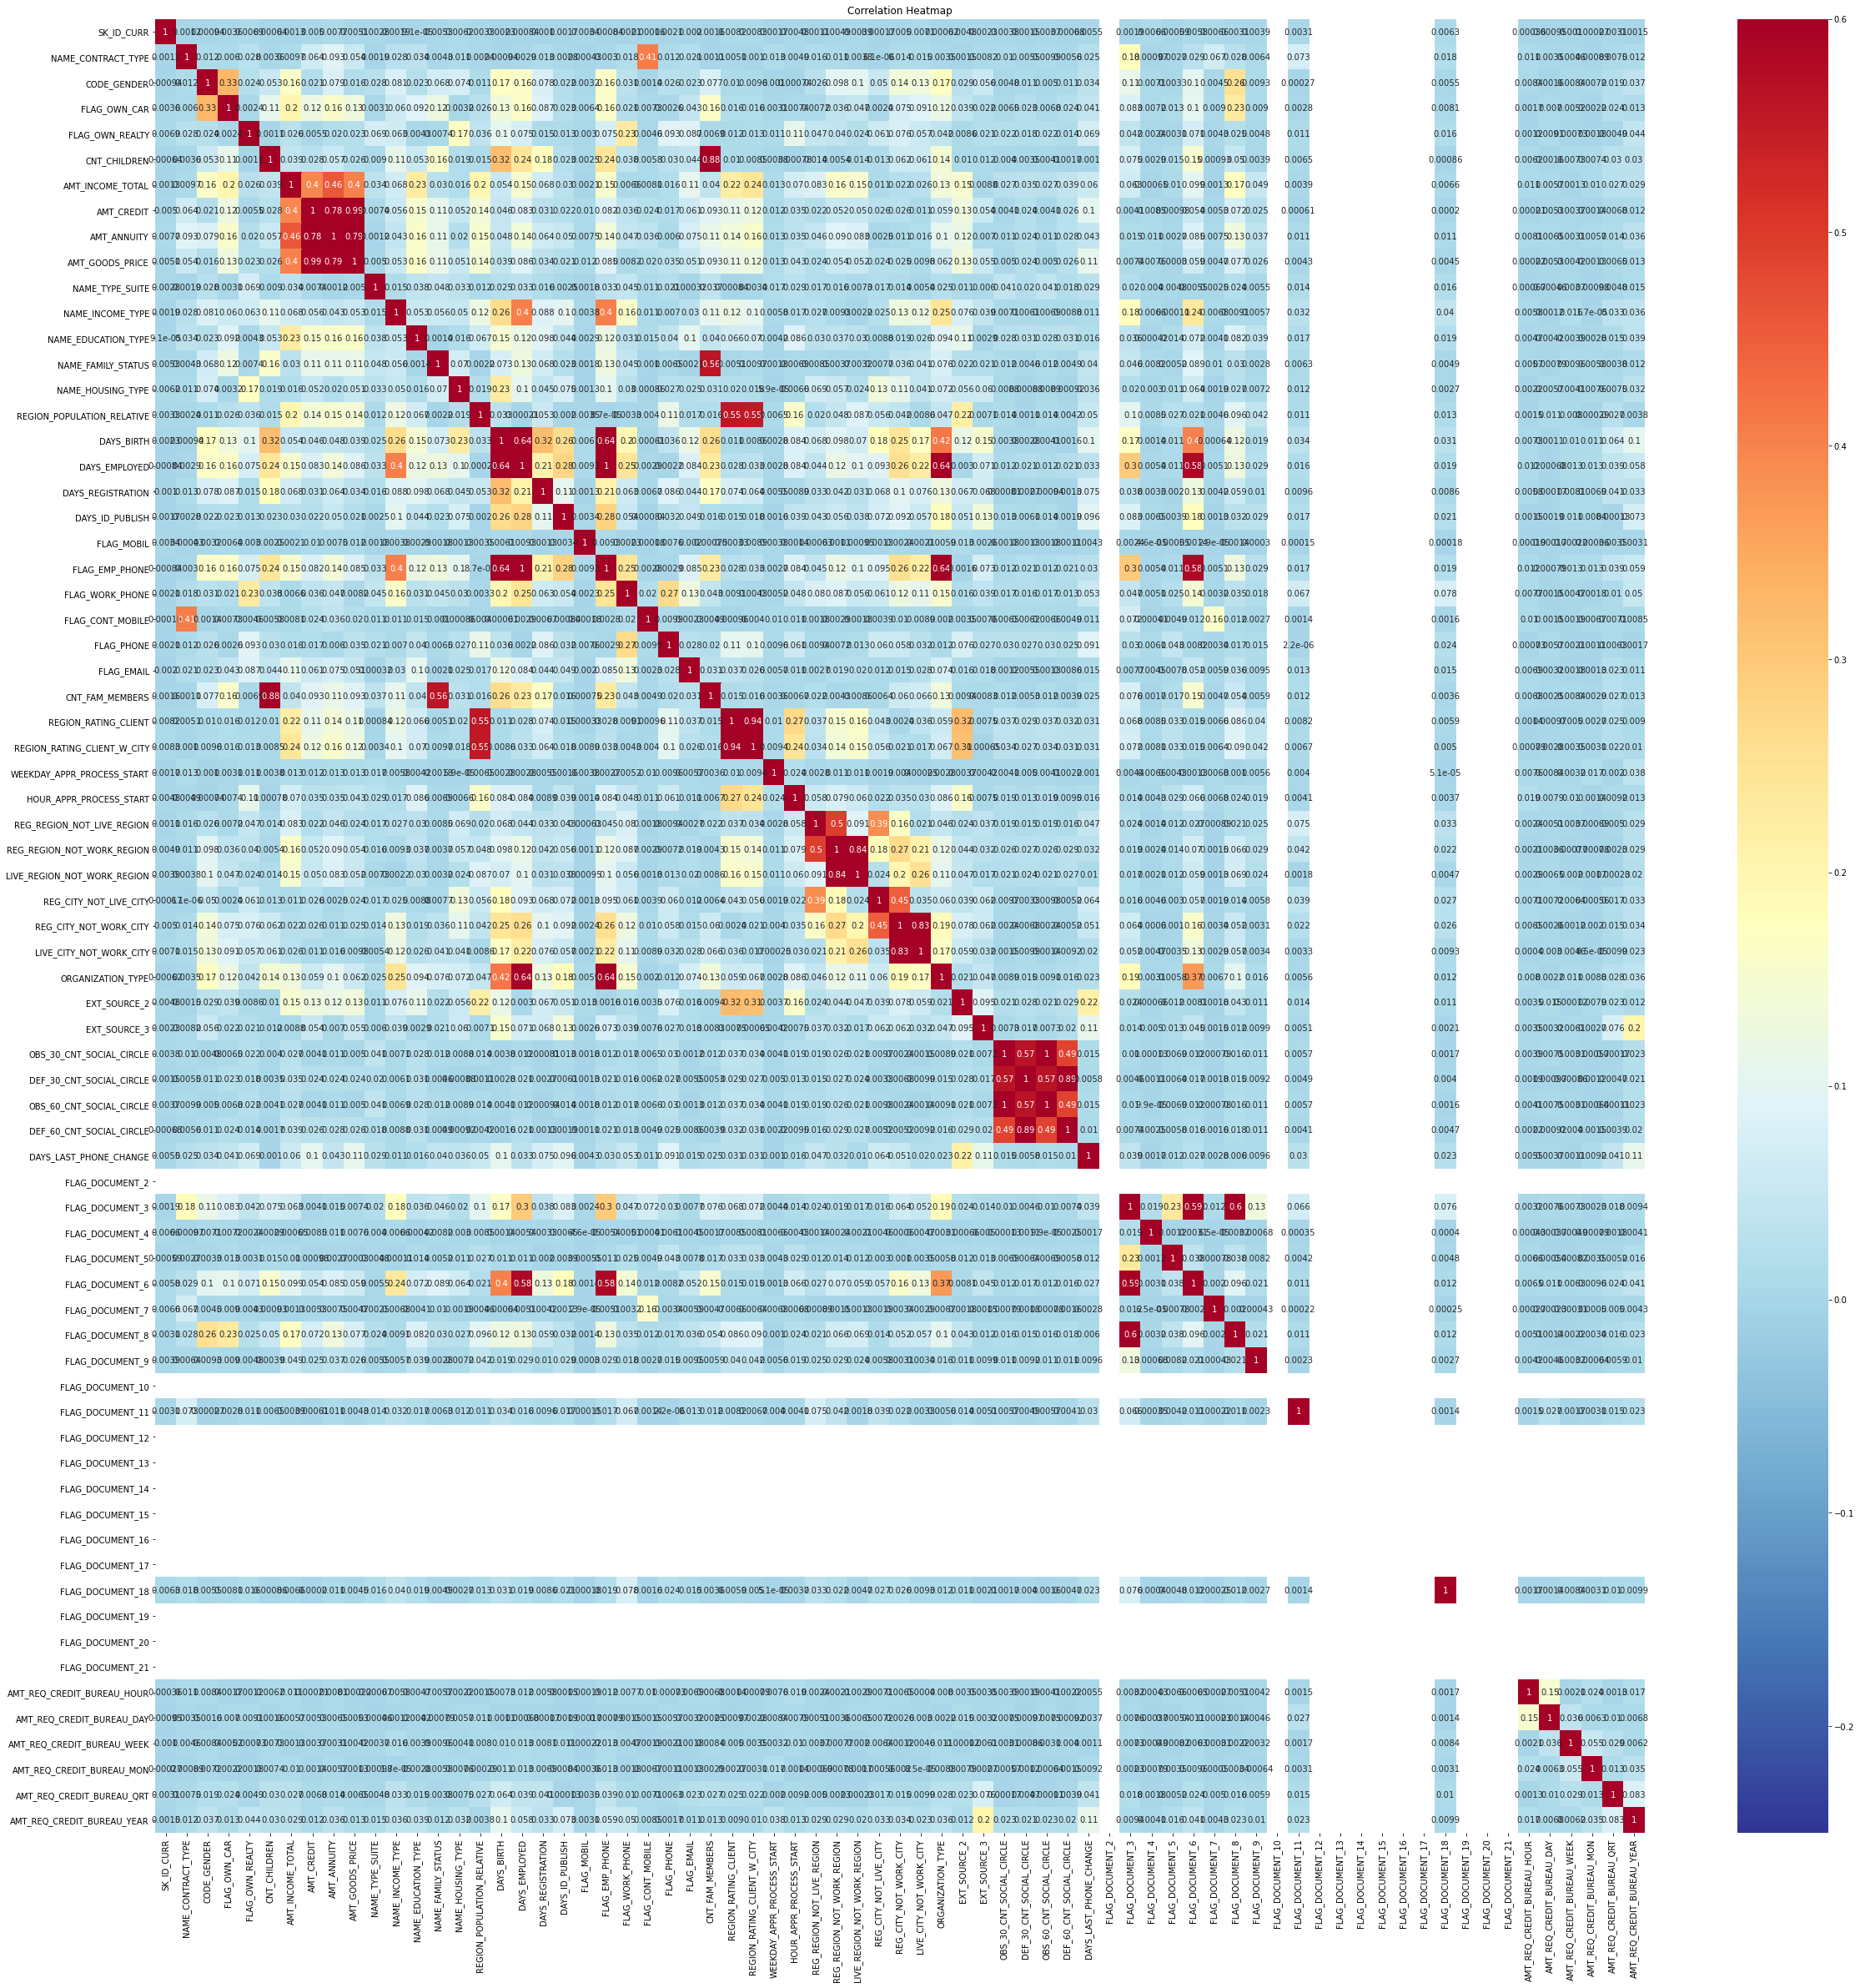

In [21]:
test_data = train_test_pipeline(test_data)

Text(0.5, 1.0, 'Correlation Heatmap')

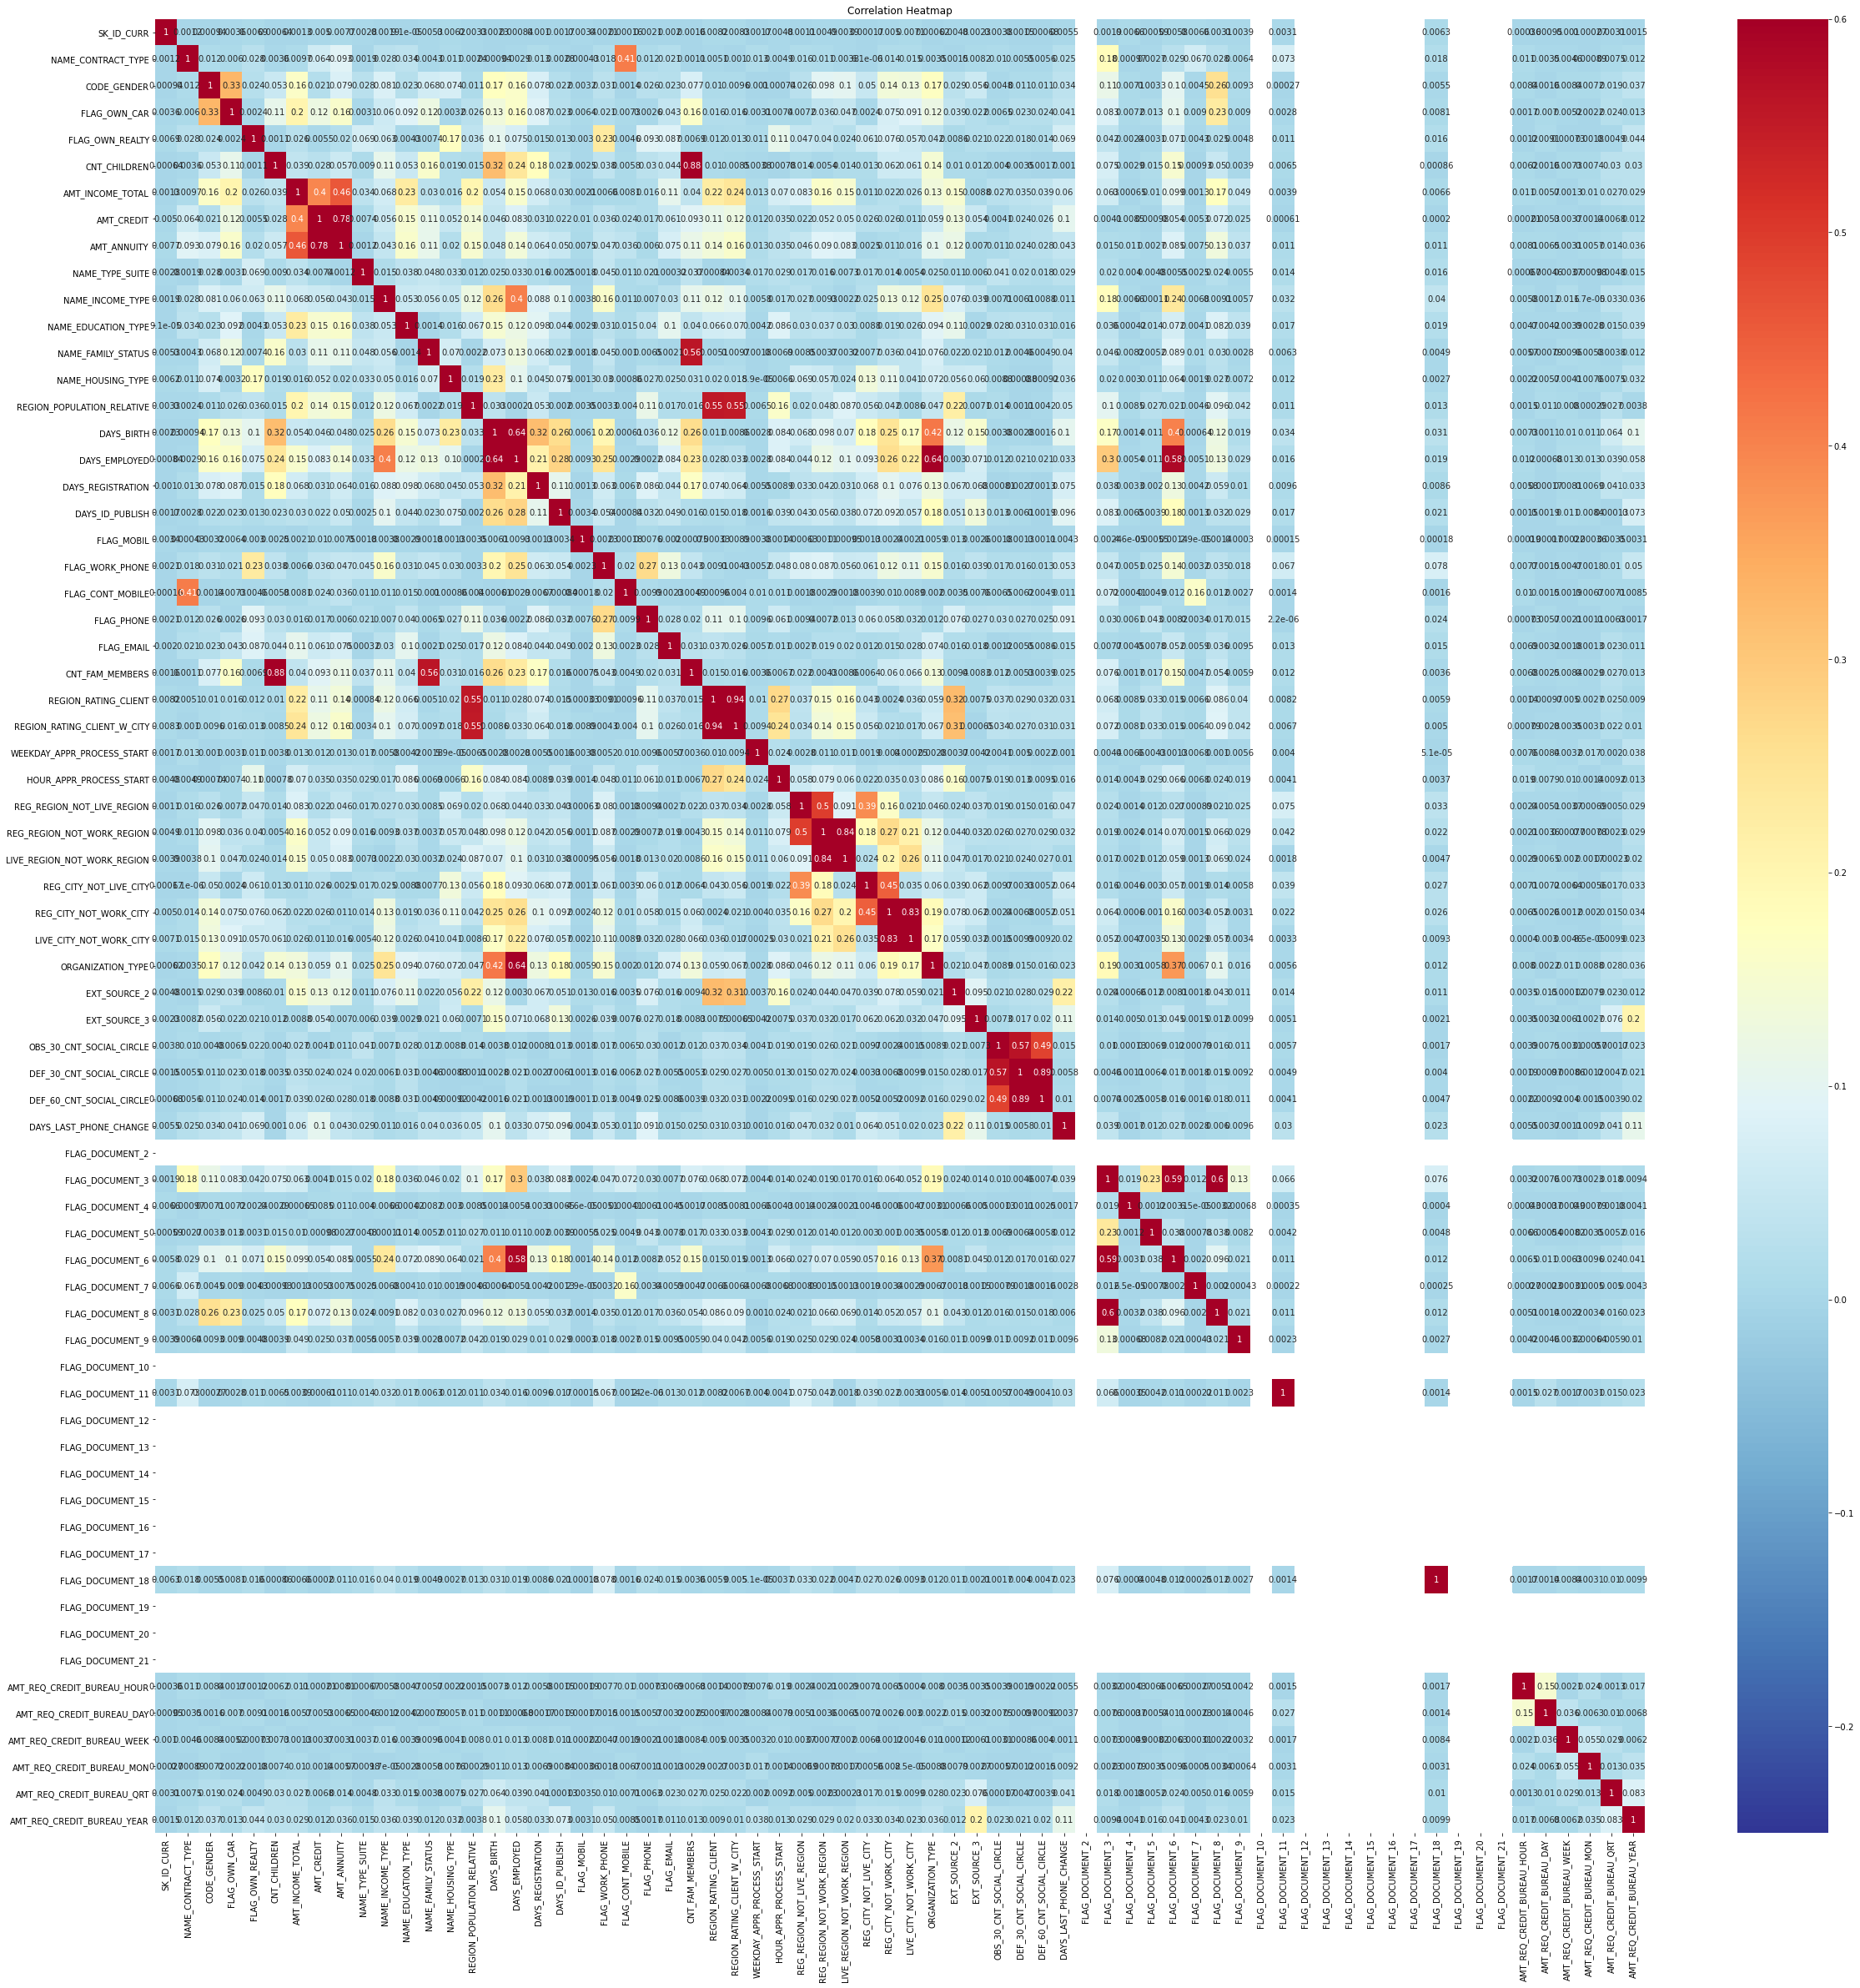

In [22]:
plt.figure(figsize=(40,40))

test_data_corr=test_data.corr().abs()
sns.heatmap(test_data_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

# Train and Test Data Understanding

## Predicting column

In [23]:
train_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

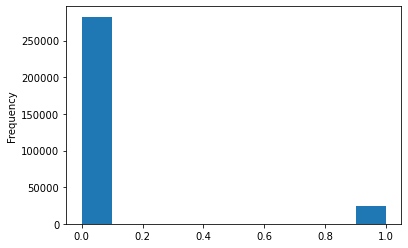

In [24]:
train_data['TARGET'].astype(int).plot.hist()

## Data Visualization

In [25]:
train_data.dtypes.value_counts()

int64      39
float64    18
int32      11
dtype: int64

In [26]:
#https://stackoverflow.com/questions/51645195/pandas-align-function-illustrative-example
train_labels=train_data['TARGET']
train_data, test_dat = train_data.align(test_data,join='inner',axis=1)
train_data['TARGET']=train_labels

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

Training Features shape:  (307511, 68)
Testing Features shape:  (48744, 68)


In [27]:
desc=description_df[description_df['Table']=='application_{train|test}.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_CURR : ID of loan in our sample

TARGET : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

NAME_CONTRACT_TYPE : Identification if loan is cash or revolving

CODE_GENDER : Gender of the client

FLAG_OWN_CAR : Flag if the client owns a car

FLAG_OWN_REALTY : Flag if client owns a house or flat

CNT_CHILDREN : Number of children the client has

AMT_INCOME_TOTAL : Income of the client

AMT_CREDIT : Credit amount of the loan

AMT_ANNUITY : Loan annuity

AMT_GOODS_PRICE : For consumer loans it is the price of the goods for which the loan is given

NAME_TYPE_SUITE : Who was accompanying client when he was applying for the loan

NAME_INCOME_TYPE : Clients income type (businessman, working, maternity leave,)

NAME_EDUCATION_TYPE : Level of highest education the client achieved

NAME_FAMILY_STATUS : Family status of the client

NAME_HOUSING_TYPE : Wha

In [28]:
# finding the number of days from the date of birth
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        print("object column %s have %s unique values"%(str(col),train_data[col].nunique()))
        print(train_data[col].value_counts())
        print('-------------')
        ax = sns.catplot(x=col, kind="count", data=train_data, height=6, aspect=2.2)
        for axes in ax.axes.flat:
            axes.set_xticklabels(axes.get_xticklabels(),rotation = 45,horizontalalignment = 'right')

Text(0.5, 1.0, 'Distribution of Ages')

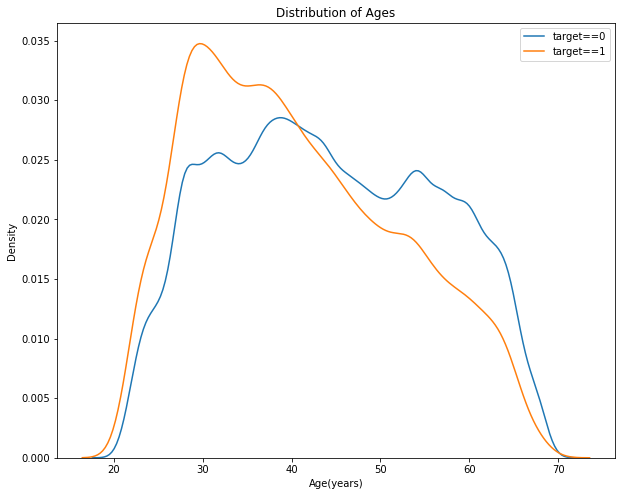

In [29]:
#converting the days into age  then see where the density of people that get accepted and rejected
plt.figure(figsize=(10,8))

train_data['DAYS_BIRTH']=train_data['DAYS_BIRTH'].abs()
sns.kdeplot(train_data.loc[train_data['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')
sns.kdeplot(train_data.loc[train_data['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')
plt.legend()
plt.xlabel('Age(years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

In [30]:
train_data[['TARGET','DAYS_BIRTH']]

TARGET  DAYS_BIRTH
0            1        9461
1            0       16765
2            0       19046
3            0       19005
4            0       19932
...        ...         ...
307506       0        9327
307507       0       20775
307508       0       14966
307509       1       11961
307510       0       16856

[307511 rows x 2 columns]

In [31]:
#converting it to years
age_data=train_data[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365
age_data


TARGET  DAYS_BIRTH  YEARS_BIRTH
0            1        9461    25.920548
1            0       16765    45.931507
2            0       19046    52.180822
3            0       19005    52.068493
4            0       19932    54.608219
...        ...         ...          ...
307506       0        9327    25.553425
307507       0       20775    56.917808
307508       0       14966    41.002740
307509       1       11961    32.769863
307510       0       16856    46.180822

[307511 rows x 3 columns]

In [32]:
# Bin the age data ( putting people in age group by using linspace is a grouping of every 5 years)
age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [33]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

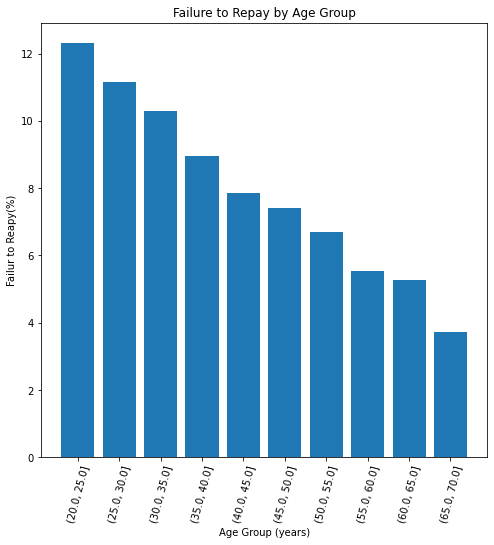

In [34]:
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failur to Reapy(%)')
plt.title('Failure to Repay by Age Group');

In [35]:
ext_data=train_data[['TARGET','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs=ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.159030     -0.119572   -0.078239
EXT_SOURCE_2 -0.159030      1.000000      0.096665    0.090487
EXT_SOURCE_3 -0.119572      0.096665      1.000000    0.151220
DAYS_BIRTH   -0.078239      0.090487      0.151220    1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

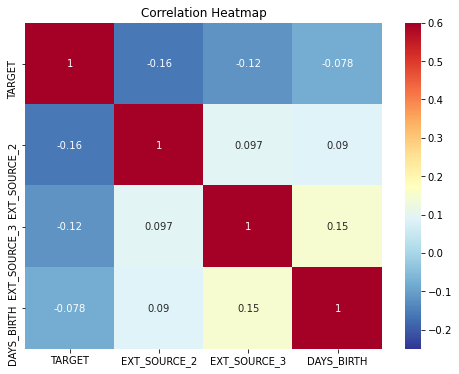

In [36]:
# find relation with target value to see if some columns has relatioons
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

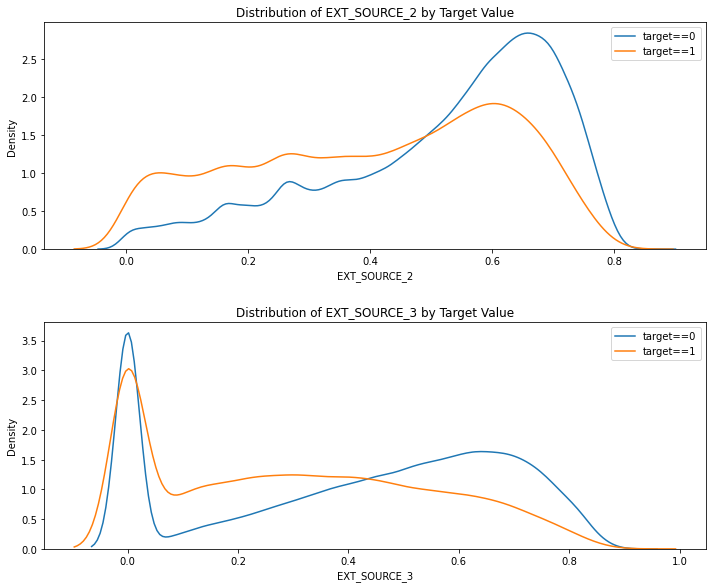

In [37]:
#this is to see if EXT sources does provide a reason to make the decision of begging accepted or denied
plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(train_data.loc[train_data['TARGET']==0,source],label='target==0')
    sns.kdeplot(train_data.loc[train_data['TARGET']==1,source],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad=2.5)

In [38]:
# converting the funds to % and see if the percentage of there funds would give them a chance to get accepted
train_data_domain = train_data.copy()

train_data_domain['CREDIT_INCOME_PERCENT'] = train_data_domain['AMT_CREDIT'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['ANNUITY_INCOME_PERCENT'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['CREDIT_TERM'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_CREDIT']
train_data_domain['DAYS_EMPLOYED_PERCENT'] = train_data_domain['DAYS_EMPLOYED'] / train_data_domain['DAYS_BIRTH']

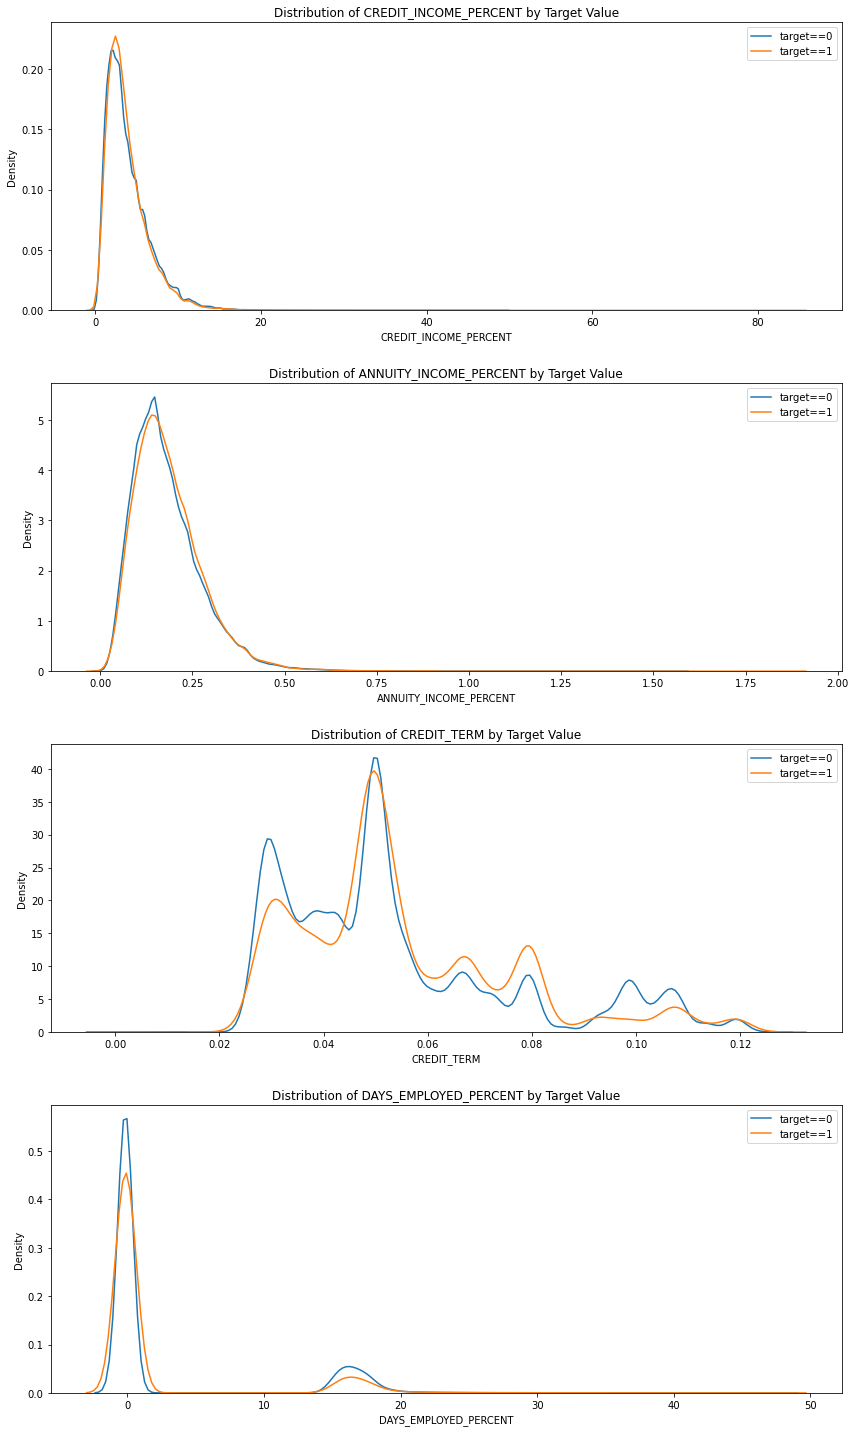

In [39]:
plt.figure(figsize=(12,20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==0,feature],label='target==0')
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==1,feature],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad=2.5)

In [40]:
# it shows there's no relevance between the all charts based on the his income and years of works

# Cleaning/Visualization - Credit Card Balance & Installments Payments

## Credit Card Balance

In [41]:
#CCB=pd.read_csv(files[5])

In [42]:
desc=description_df[description_df['Table']=='credit_card_balance.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

SK_ID_CURR : ID of loan in our sample

MONTHS_BALANCE : Month of balance relative to application date (-1 means the freshest balance date)

AMT_BALANCE : Balance during the month of previous credit

AMT_CREDIT_LIMIT_ACTUAL : Credit card limit during the month of the previous credit

AMT_DRAWINGS_ATM_CURRENT : Amount drawing at ATM during the month of the previous credit

AMT_DRAWINGS_CURRENT : Amount drawing during the month of the previous credit

AMT_DRAWINGS_OTHER_CURRENT : Amount of other drawings during the month of the previous credit

AMT_DRAWINGS_POS_CURRENT : Amount drawing or buying goods during the month of the previous credit

AMT_INST_MIN_REGULARITY : Minimal installment for this month of the previous credit

AMT_PAYMENT_CURRENT : How much did the client pay during the month on the previous credit

AMT_PAYMENT_TOTA

In [43]:
CCB#.describe()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  \
0                           877.5                 1700.325   
1                             0.0                 2250.000   
2                             0.0                 2250.000   
3                             0.0                11795.760   
4                         11547.0                22924.890   
...                           ...                      ...   
3840307                       NaN                    0.000   
3840308                       0.0                    0.000   
3840309                       0.0                 2250.000   
3840310                       NaN                    0.000   
3840311                       0.0                    0.000   

         AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                    1800.00                   1800.000   
1                    2250.00                   2250.000   
2                    2250.00                   2250.000   
3                   11925.00                  11925.000   
4                   27000.00                  27000.000   
...                      ...                        ...   
3840307                  NaN                      0.000   
3840308              1879.11                      0.000   
3840309            375750.00                 356994.675   
3840310                  NaN                      0.000   
3840311                 0.00                      0.000   

         AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                           0.000          0.000                 0.000   
1                       60175.080      64875.555             64875.555   
2                       26926.425      31460.085             31460.085   
3           

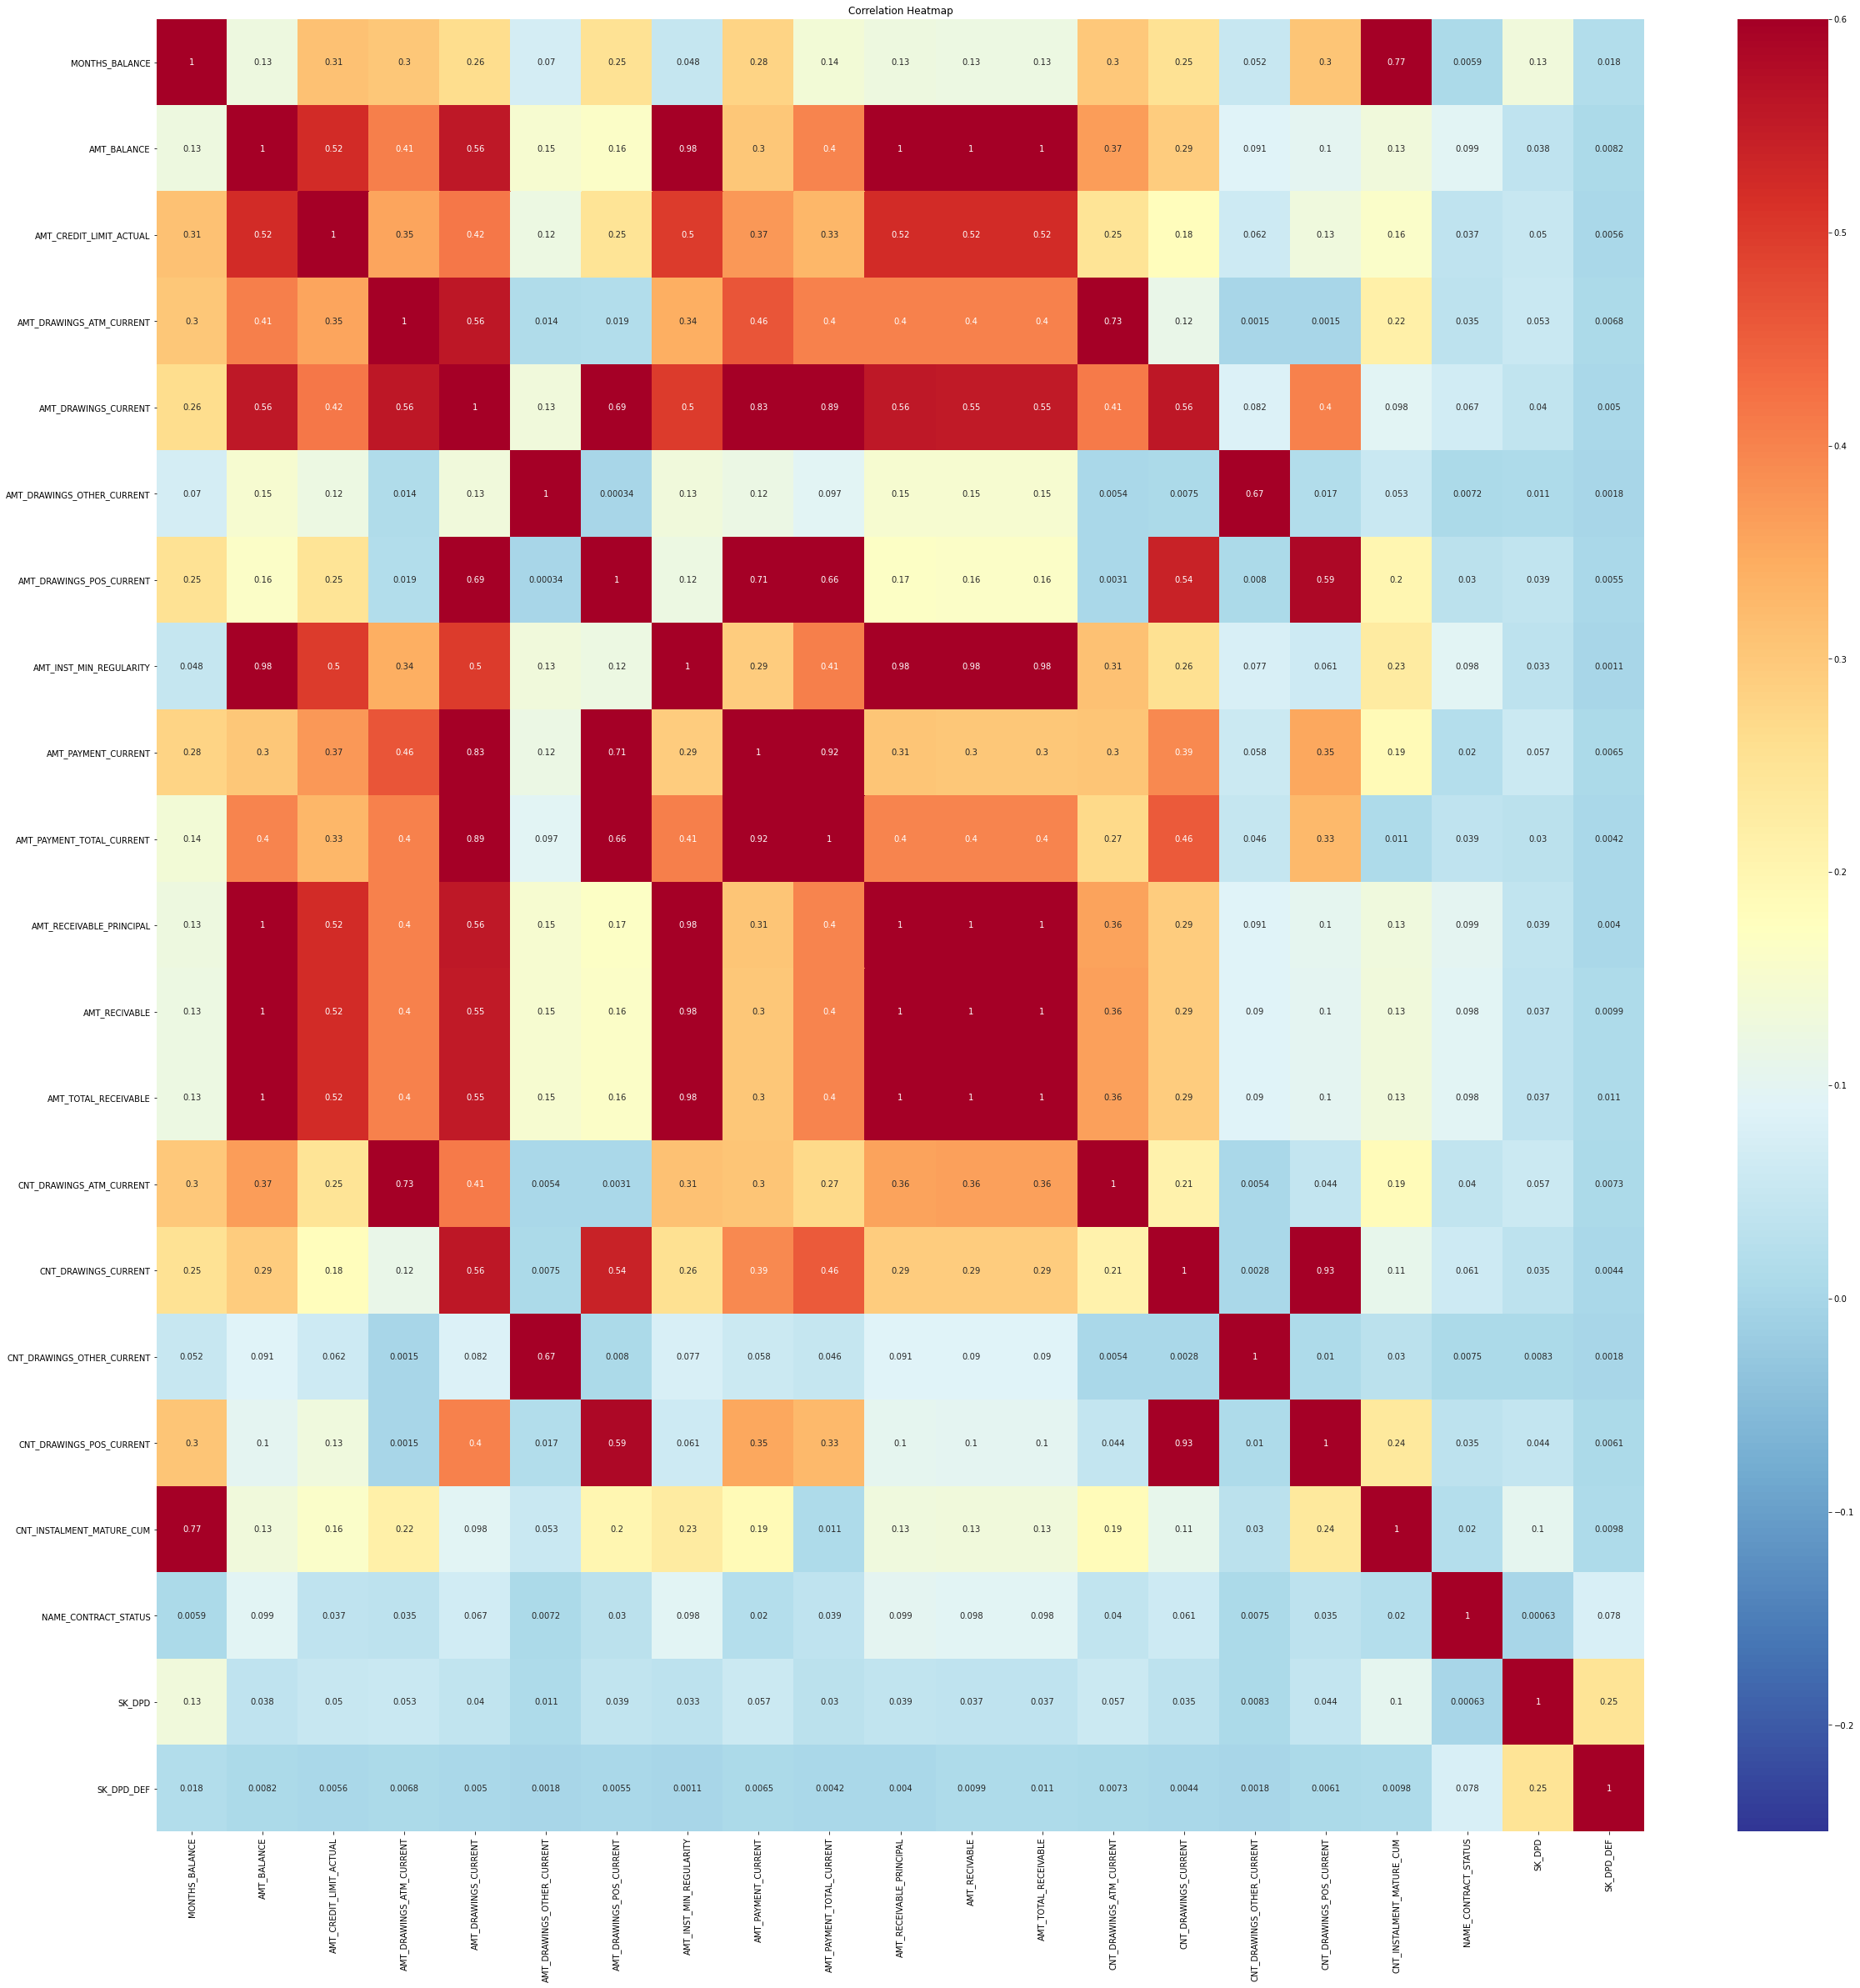

In [44]:
CCB = extra_data_pipeline(CCB)

In [45]:
CCB

MONTHS_BALANCE    AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_CURR                                                           
100006                -3.5       0.000000            270000.000000   
100011               -38.5   54482.111149            164189.189189   
100013               -48.5   18159.919219            131718.750000   
100021               -10.0       0.000000            675000.000000   
100023                -7.5       0.000000            135000.000000   
...                    ...            ...                      ...   
456244               -21.0  131834.730732            296341.463415   
456246                -5.5   13136.731875            135000.000000   
456247               -49.0   23216.396211            144000.000000   
456248               -13.0       0.000000            900000.000000   
456250                -6.5  173589.326250            178875.000000   

            AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                   
100006                  12018.179117              0.000000   
100011                   2432.432432           2432.432432   
100013                   6350.000000           5953.125000   
100021                  12018.179117              0.000000   
100023                  12018.179117              0.000000   
...                              ...                   ...   
456244                  24475.609756          26842.388049   
456246                      0.000000          15199.256250   
456247                   2136.315789           2149.506474   
456248                  12018.179117              0.000000   
456250                  15000.000000          15000.000000   

            AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
SK_ID_CURR                                                         
100006                      583.772133               8389.181213   
100011                        0.000000                  0.000000   
100013                        0.000000                  0.000000   
100021                      583.772133               8389.181213   
100023                      583.772133               8389.181213   
...                                ...                       ...   
456244                        0.000000               2363.015854   
456246                        0.000000              15199.256250   
456247                        0.000000                 13.190684   
456248                      583.772133               8389.181213   
456250                        0.000000                  0.000000   

            AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
SK_ID_CURR                                                   
100006             17934.678567                   0.000000   
100011              4843.064189                4520.067568   
100013              7168.346250                6817.172344   
100021             17934.678567                   0.000000   
100023             17934.678567                   0.000000   
...                         ...                        ...   
456244             32720.544878               32720.544878   
456246             18778.275000               15554.340000   
456247              4883.755263                4115.878105   
456248             17934.678567                   0.000000   
456250             10748.250000                1622.820000   

            CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                   
100006                      0.546925              0.000000   
100011                      0.054054              0.054054   
100013                      0.255556              0.239583   
100021                      0.546925              0.000000   
100023                      0.546925              0.000000   
...                              ...                   ...   
456244                      1.048780              1.365854   
456246                      0.000000        

Text(0.5, 1.0, 'Correlation Heatmap')

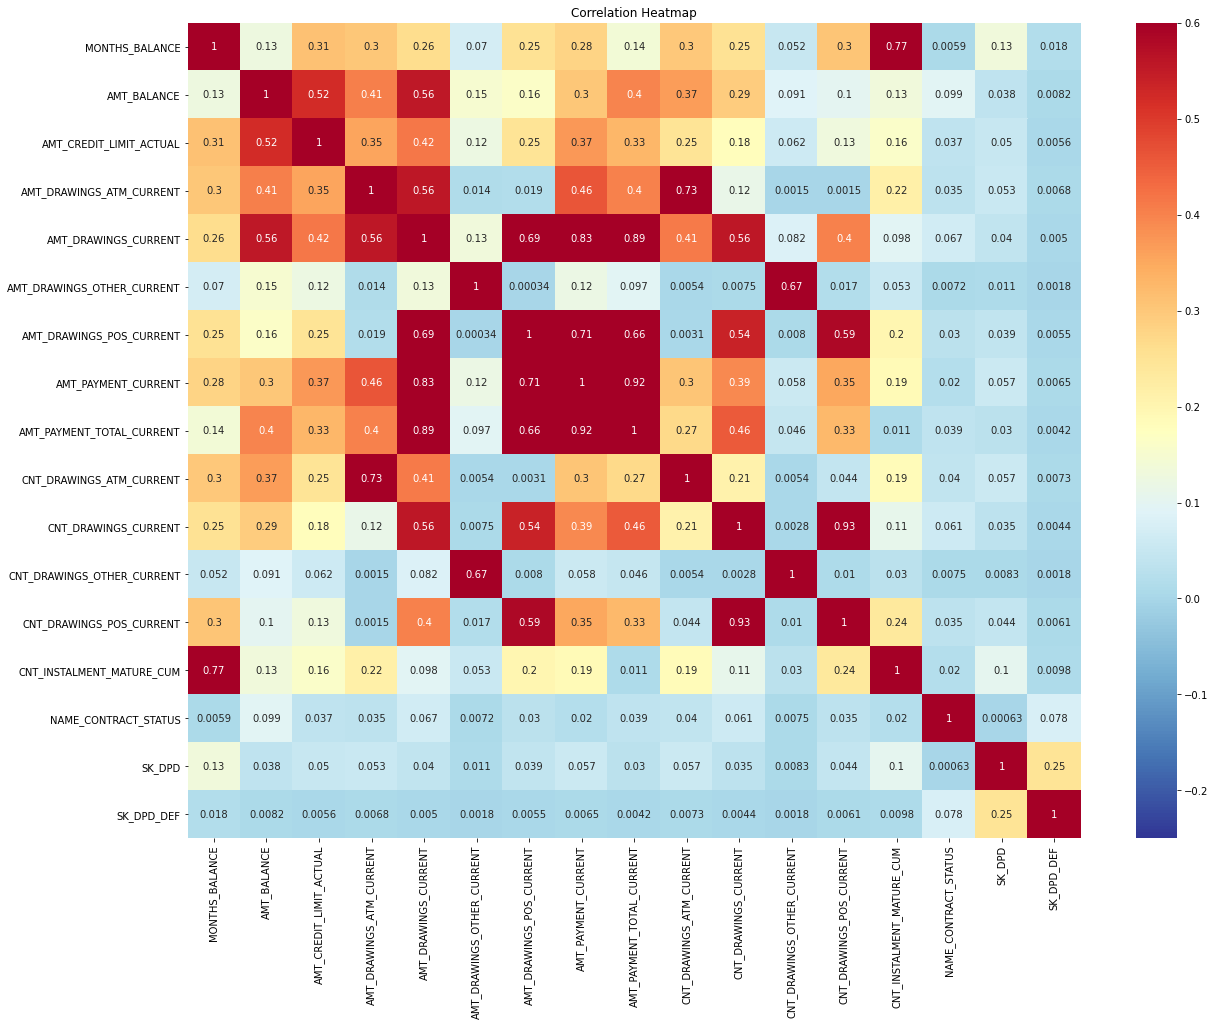

In [46]:
plt.figure(figsize=(20,15))

CCB_corr=CCB.corr().abs()
sns.heatmap(CCB_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

## Installments Payments

In [47]:
#IP=pd.read_csv(files[6])

In [48]:
desc=description_df[description_df['Table']=='installments_payments.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

SK_ID_CURR : ID of loan in our sample

NUM_INSTALMENT_VERSION : Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed

NUM_INSTALMENT_NUMBER : On which installment we observe payment

DAYS_INSTALMENT : When the installment of previous credit was supposed to be paid (relative to application date of current loan)

DAYS_ENTRY_PAYMENT : When was the installments of previous credit paid actually (relative to application date of current loan)

AMT_INSTALMENT : What was the prescribed installment amount of previous credit on this installment

AMT_PAYMENT : What the client actually paid on previous credit on this installment



In [49]:
IP.describe()

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

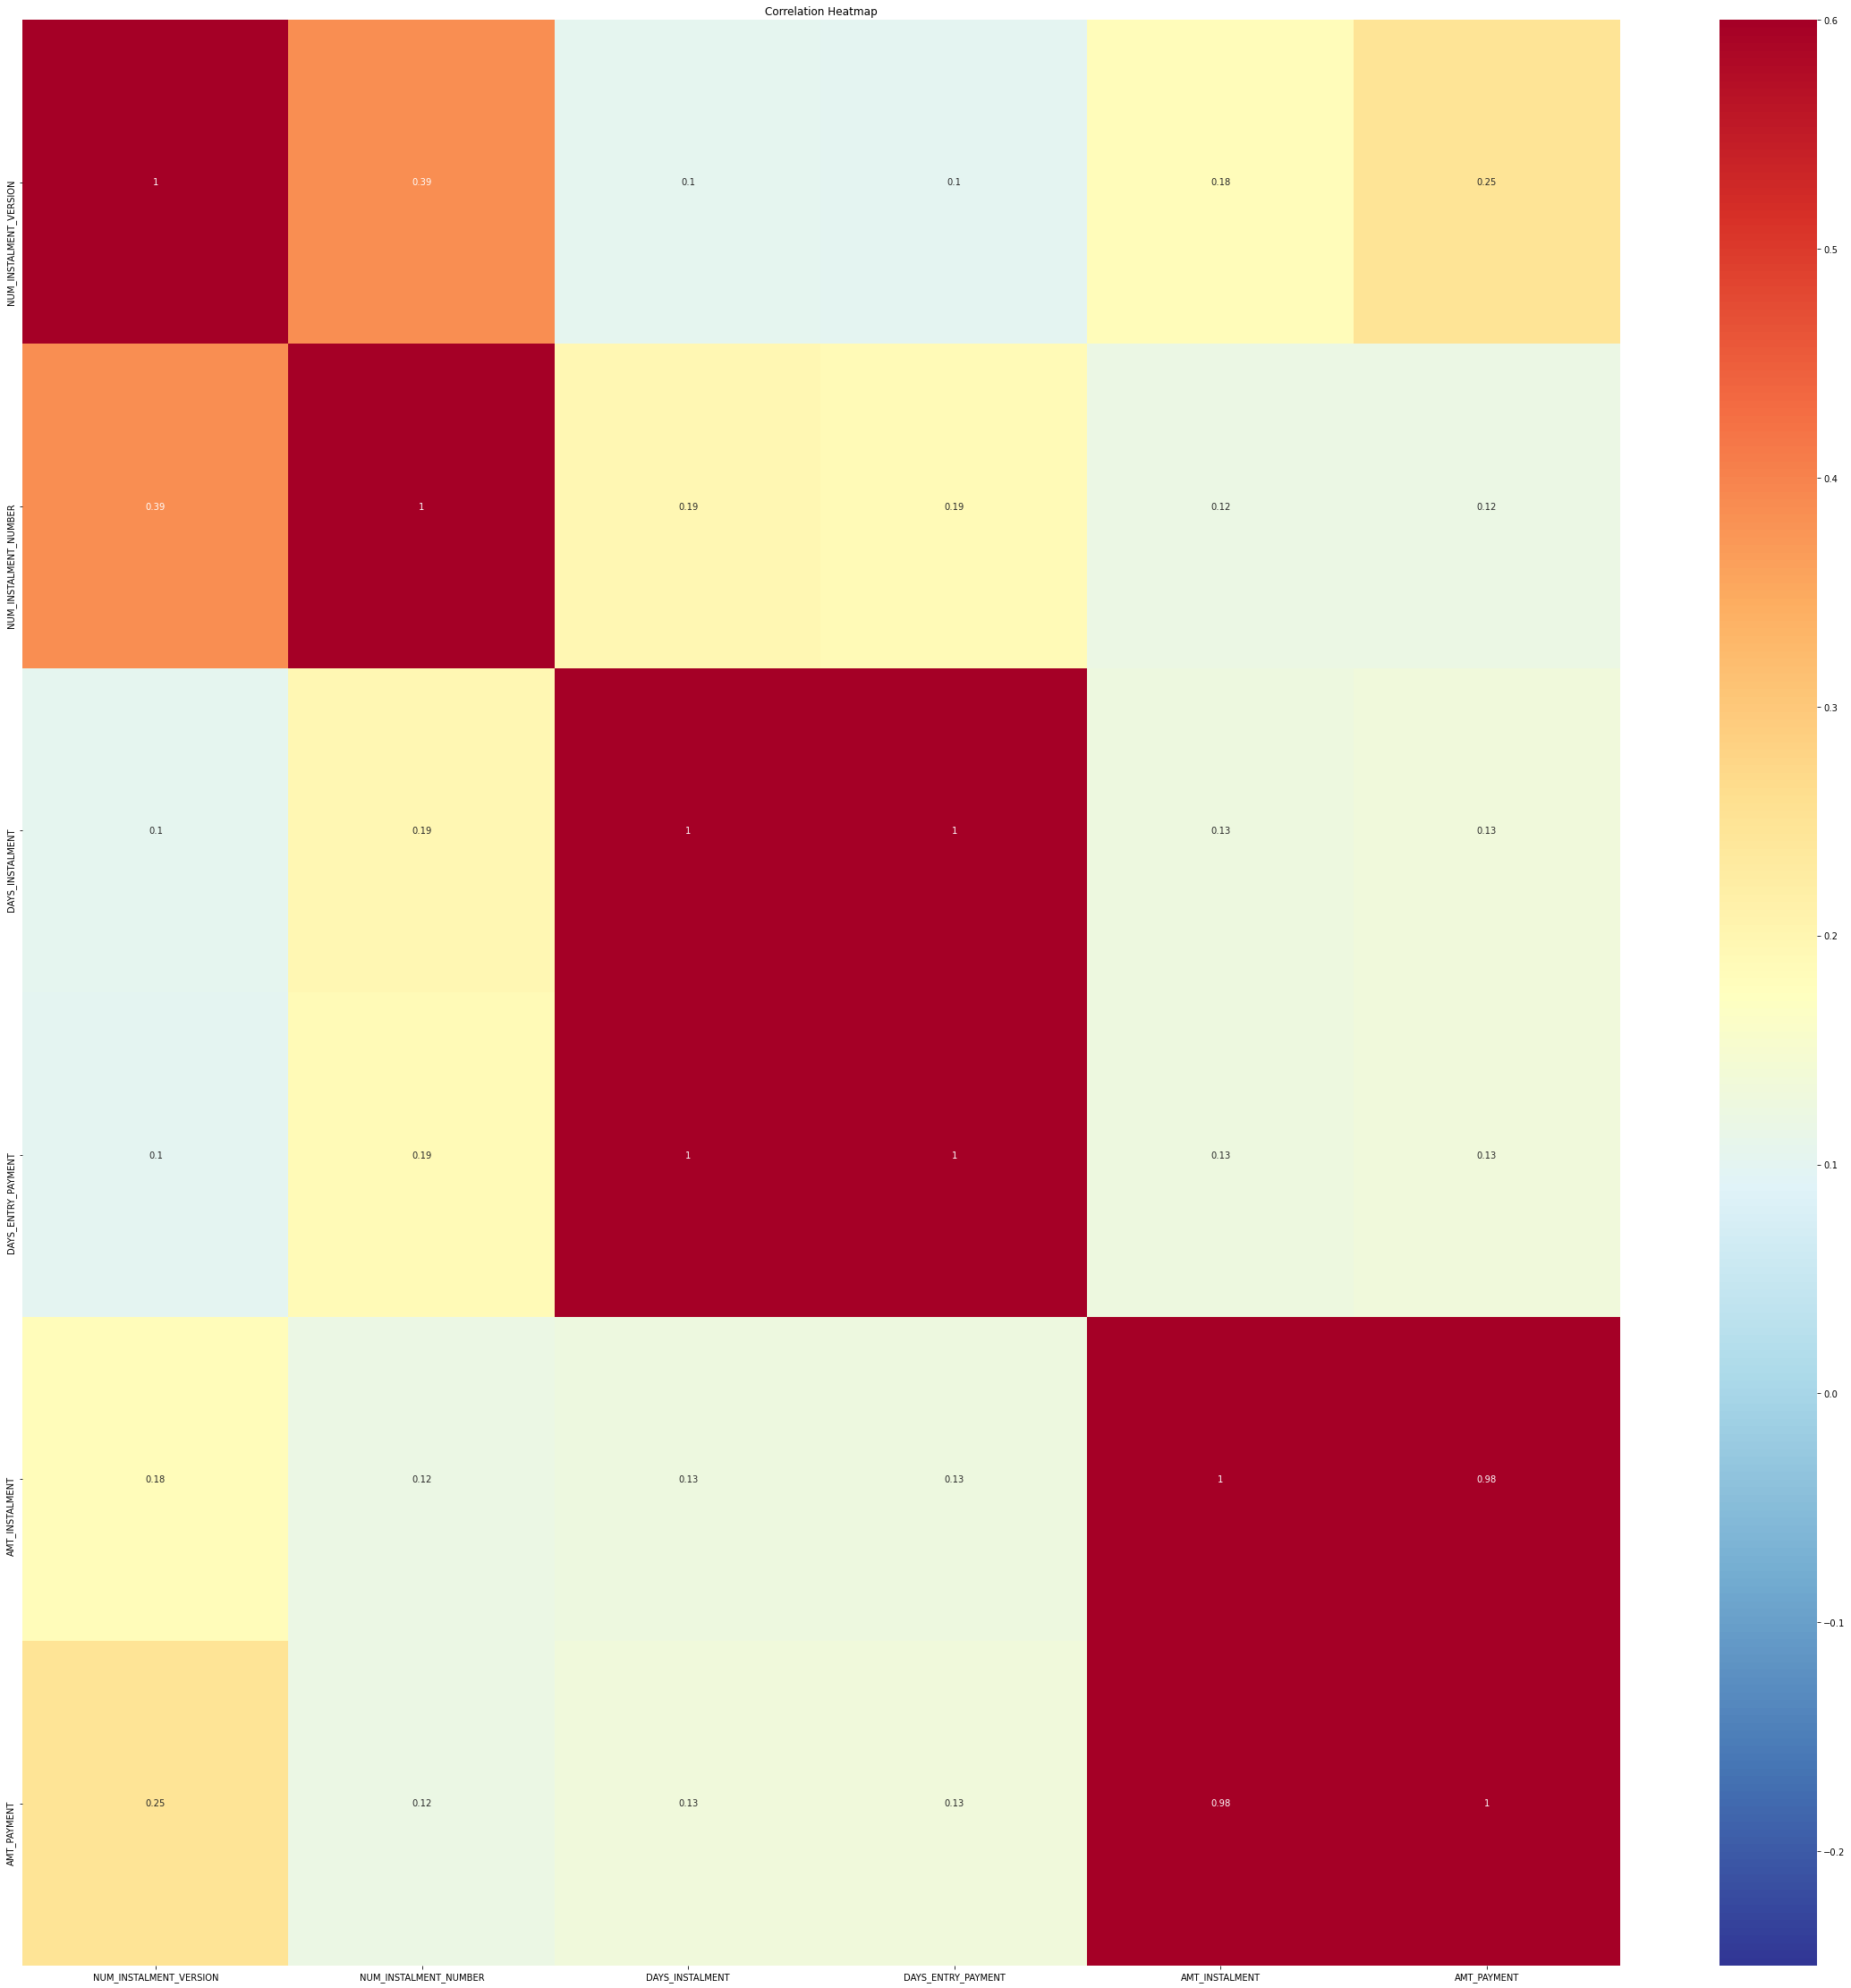

In [50]:
IP = extra_data_pipeline(IP)

In [51]:
IP

NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
SK_ID_CURR                                                                   
100001                    1.142857               2.714286     -2187.714286   
100002                    1.052632              10.000000      -295.000000   
100003                    1.040000               5.080000     -1378.160000   
100004                    1.333333               2.000000      -754.000000   
100005                    1.111111               5.000000      -586.000000   
...                            ...                    ...              ...   
456251                    1.142857               4.000000      -120.000000   
456252                    1.000000               3.500000     -2391.000000   
456253                    1.000000               4.785714     -2372.928571   
456254                    1.000000               5.263158      -142.263158   
456255                    1.824324               8.851351      -463.945946   

            AMT_INSTALMENT  
SK_ID_CURR                  
100001         5885.132143  
100002        11559.247105  
100003        64754.586000  
100004         7096.155000  
100005         6240.205000  
...                    ...  
456251         7492.924286  
456252        10069.867500  
456253         4399.707857  
456254        10239.832895  
456255        41464.713649  

[339587 rows x 4 columns]

Text(0.5, 1.0, 'Correlation Heatmap')

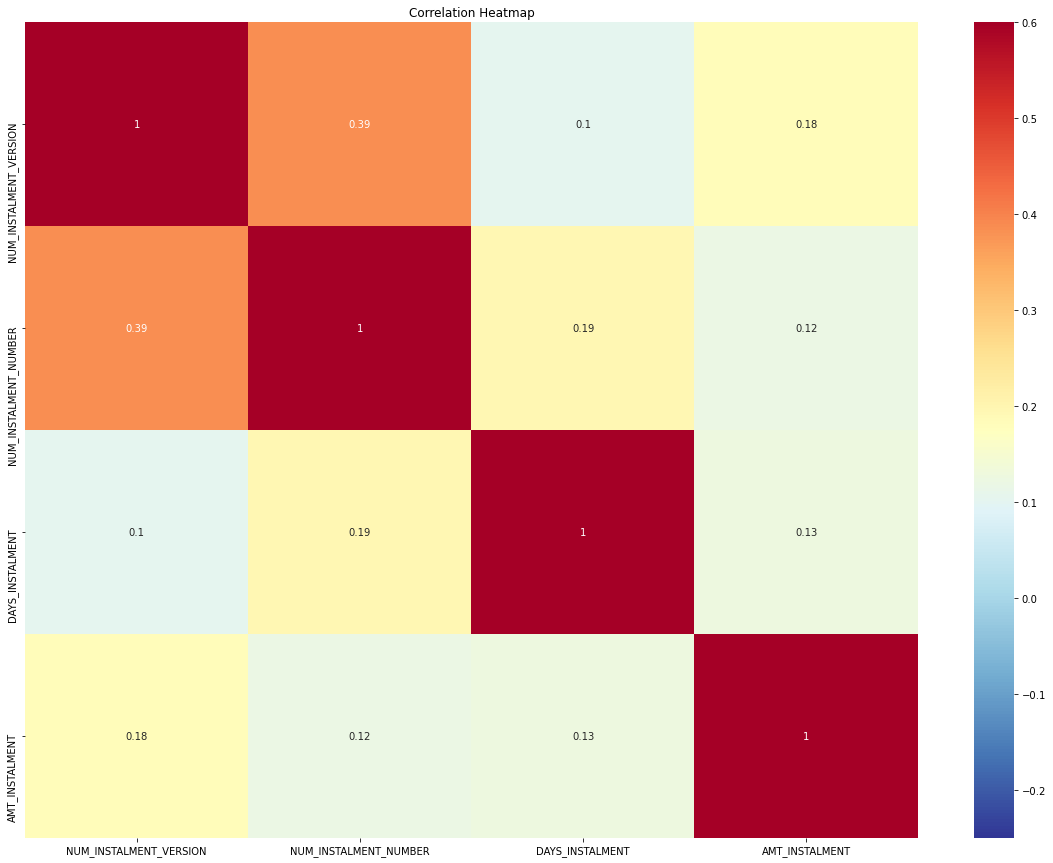

In [52]:
plt.figure(figsize=(20,15))

CCB_corr=IP.corr().abs()
sns.heatmap(CCB_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

## Previous Application

In [53]:
PA=pd.read_csv(files[10])

In [54]:
PA

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1670209                  WEDNESDAY                       12   
1670210                    TUESDAY                       15   
1670211                     MONDAY                       12   
1670212                  WEDNESDAY                        9   
1670213                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
1670209                           Y                       1   
1670210                           Y                       1   
1670211                           Y                       1   
1670212                           Y                       1   
1670213                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                 0.000000               0.182832                  0.867336   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
1670209           0.000000                    NaN                       NaN   
1670210           0.340554                    NaN                       NaN   
1670211           0.101401                    NaN                       NaN   

In [55]:
desc=description_df[description_df['Table']=='previous_application.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) 

SK_ID_CURR : ID of loan in our sample

NAME_CONTRACT_TYPE : Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application

AMT_ANNUITY : Annuity of previous application

AMT_APPLICATION : For how much credit did client ask on the previous application

AMT_CREDIT : Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT

AMT_DOWN_PAYMENT : Down payment on the previous application

AMT_GOODS_PRICE : Goods price of good that client asked for (if applicable) on the previous application

WEEKDAY_APPR_PROCESS_START : On whic

In [56]:
#PA.drop(['SK_ID_PREV'], axis=1, inplace=True)
PA.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  \
count            5951.000000               5951.000000   1.670214e+06   
mean                0.188357                  0.773503  -8.806797e+02   
std                 0.087671                  0.100879   7.790997e+02   
min                 0.034781                  0.373150  -2.922000e+03   
25%                 0.160716                  0.715645  -1.300000e+03   
50%                 0.189122                  0.835095  -5.810000e+02   
75%                 0.193330                  0.852537  -2.800000e+02   
max                 1.000000                  1.000000  -1.000000e+00   

       SELLERPLACE_AREA   CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count      1.670214e+06  1.297984e+06       997149.000000   997149.000000   
mean       3.139511e+02  1.605408e+01       342209.855039    13826.269337   
std        7.127443e+03  1.456729e+01        88916.115834    72444.869708   
min       -1.000000e+00  0.000000e+00        -2922.000000    -2892.000000   
25%       -1.000000e+00  6.000000e+00       365243.000000    -1628.000000   
50%        3.000000e+00  1.200000e+01       365243.000000     -831.000000   
75%        8.200000e+01  2.400000e+01       365243.000000     -411.000000   
max        4.000000e+06  8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.0000

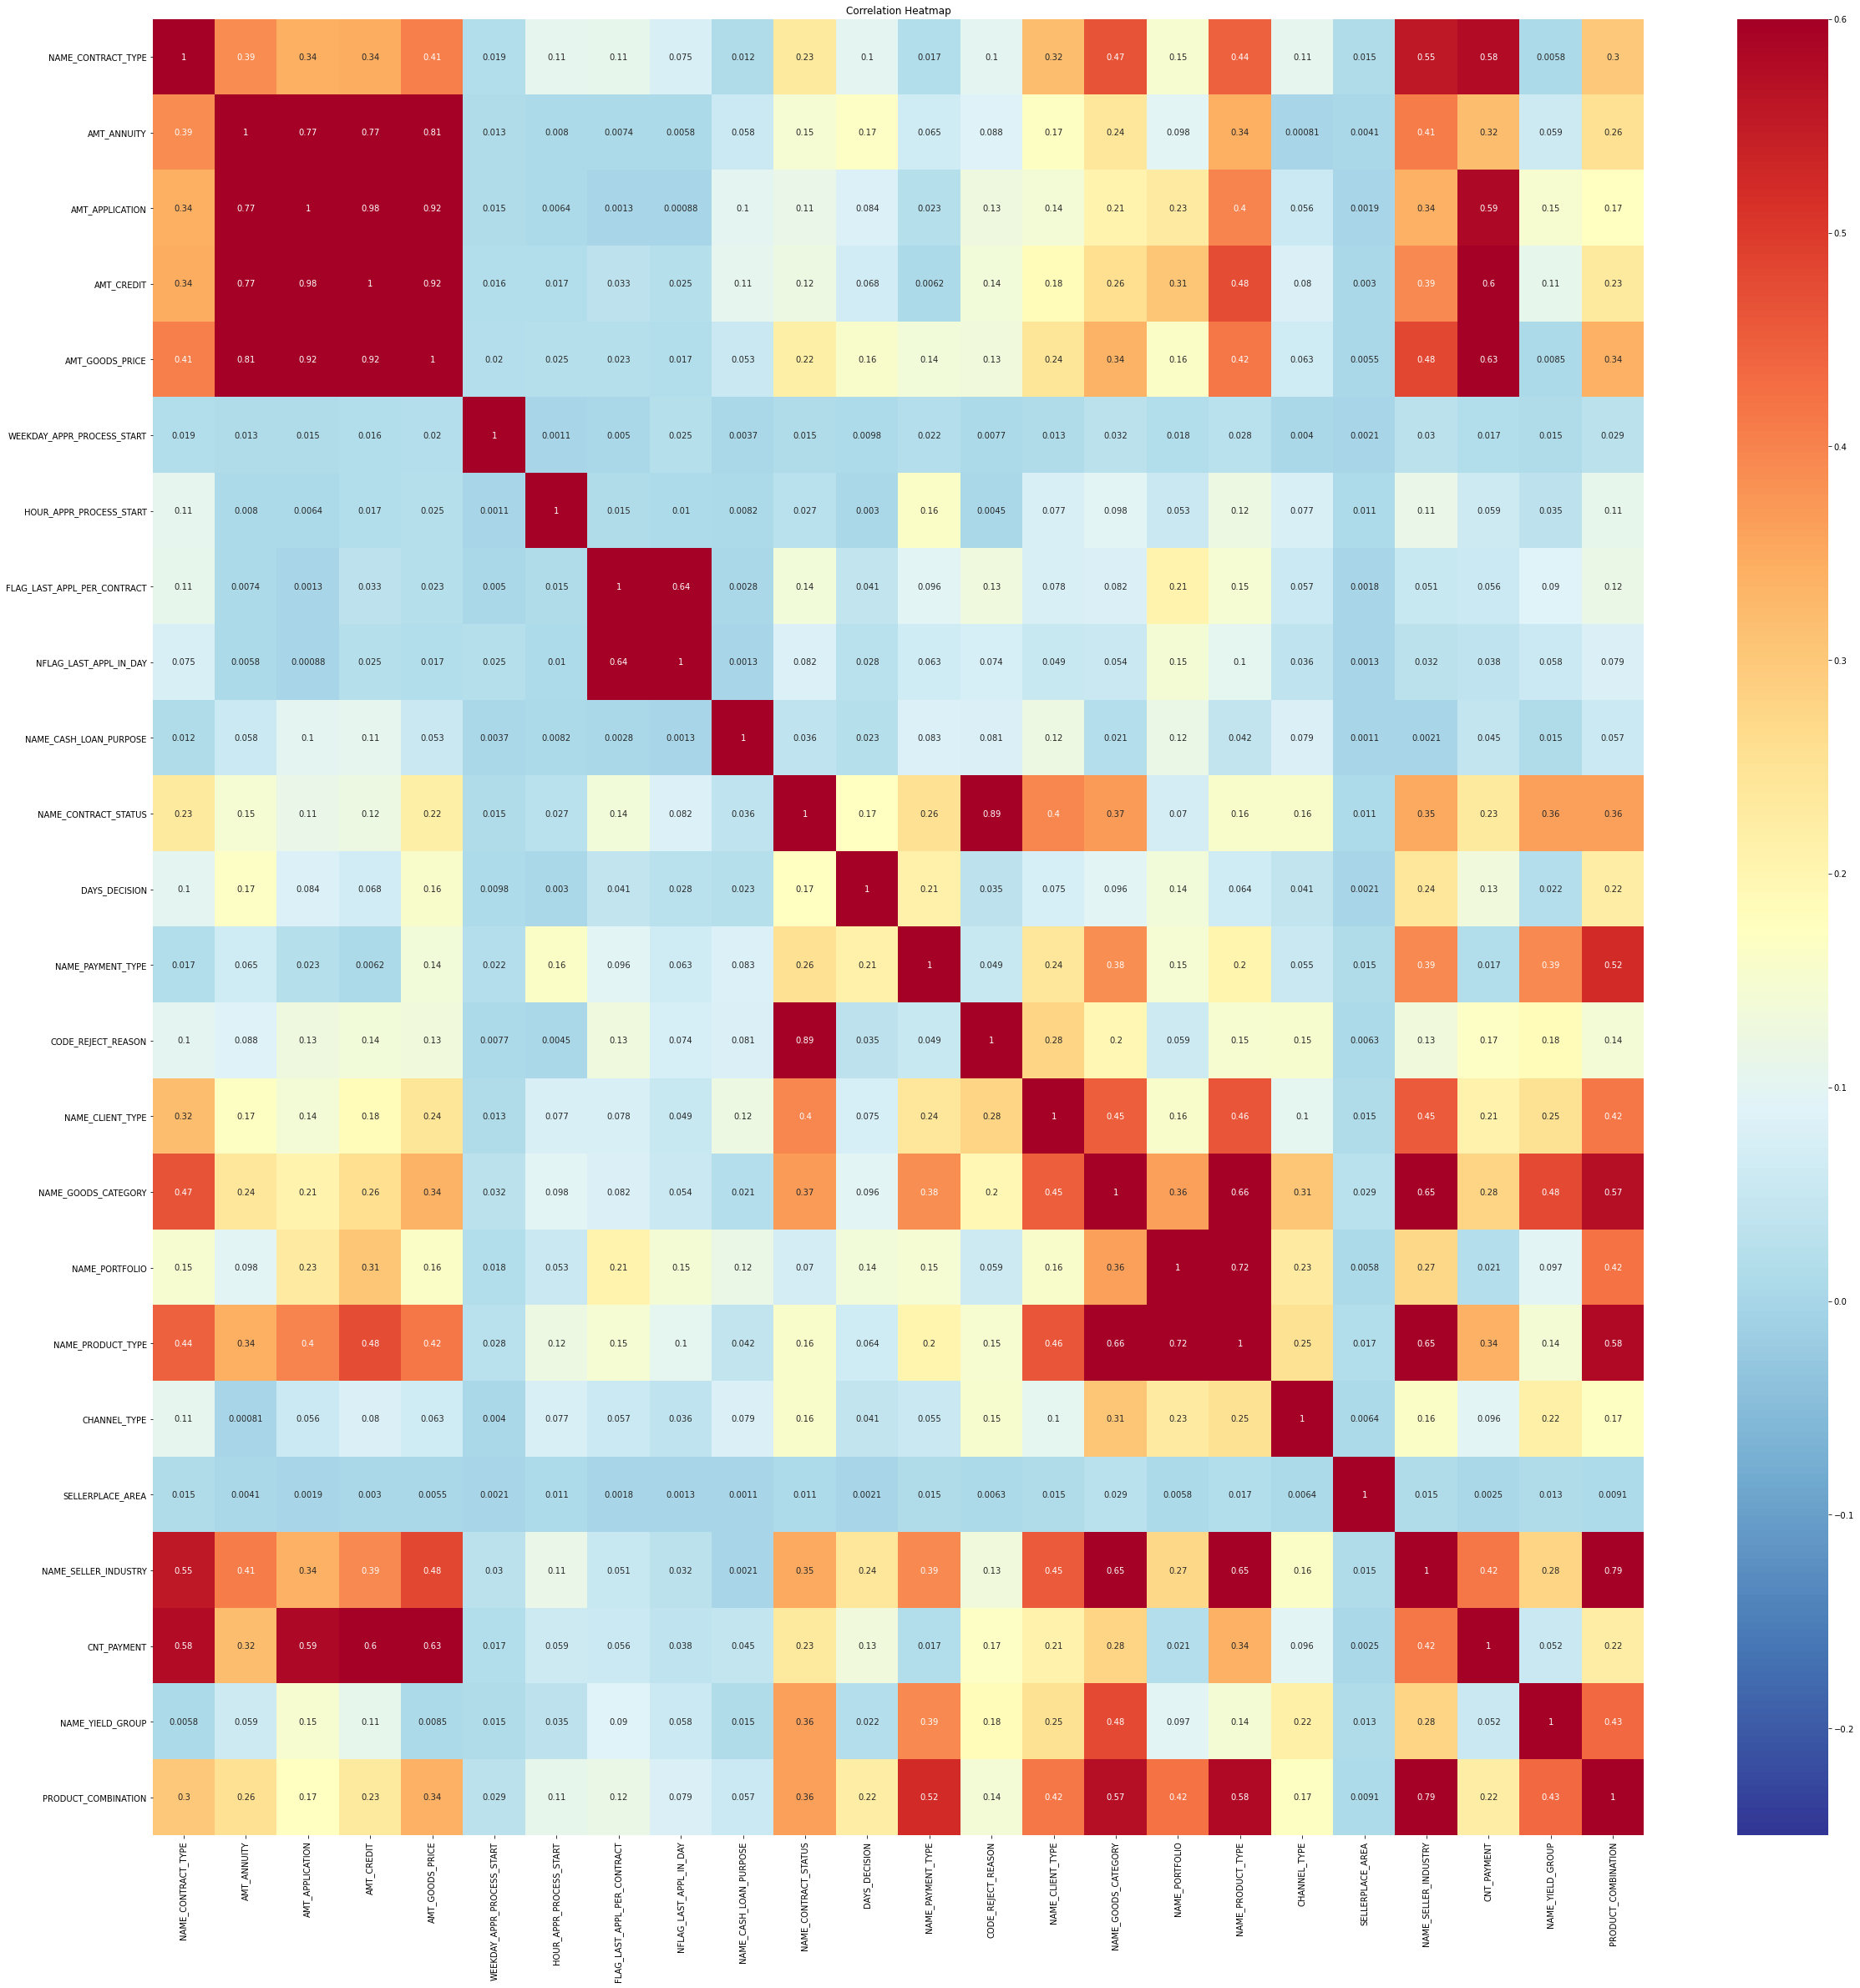

In [57]:
PA = extra_data_pipeline(PA)

In [58]:
PA

NAME_CONTRACT_TYPE   AMT_ANNUITY  AMT_APPLICATION  \
SK_ID_CURR                                                      
100001                1.000000   3951.000000        24835.500   
100002                1.000000   9251.775000       179055.000   
100003                0.666667  56553.990000       435436.500   
100004                1.000000   5357.250000        24282.000   
100005                0.500000   4813.200000        22308.750   
...                        ...           ...              ...   
456251                1.000000   6605.910000        40455.000   
456252                1.000000  10074.465000        57595.500   
456253                1.000000   4770.405000        24162.750   
456254                1.000000  10681.132500       121317.750   
456255                0.625000  20775.391875       362770.875   

            AMT_GOODS_PRICE  WEEKDAY_APPR_PROCESS_START  \
SK_ID_CURR                                                
100001            24835.500                    0.000000   
100002           179055.000                    2.000000   
100003           435436.500                    1.666667   
100004            24282.000                    0.000000   
100005            44617.500                    2.000000   
...                     ...                         ...   
456251            40455.000                    4.000000   
456252            57595.500                    6.000000   
456253            24162.750                    3.500000   
456254           121317.750                    4.000000   
456255           362770.875                    2.375000   

            HOUR_APPR_PROCESS_START  FLAG_LAST_APPL_PER_CONTRACT  \
SK_ID_CURR                                                         
100001                    13.000000                          1.0   
100002                     9.000000                          1.0   
100003                    14.666667                          1.0   
100004                     5.000000                          1.0   
100005                    10.500000                          1.0   
...                             ...                          ...   
456251                    17.000000                          1.0   
456252                    10.000000                          1.0   
456253                    11.500000                          1.0   
456254                    15.000000                          1.0   
456255                    14.625000                          1.0   

            NFLAG_LAST_APPL_IN_DAY  NAME_CASH_LOAN_PURPOSE  \
SK_ID_CURR                                                   
100001                         1.0               23.000000   
100002                         1.0               23.000000   
100003                         1.0               23.333333   
100004                         1.0               23.000000   
100005                         1.0               23.500000   
...                            ...                     ...   
456251                         1.0               23.000000   
456252                         1.0               23.000000   
456253                         1.0               23.000000   
456254                         1.0               23.000000   
456255                         1.0               23.000000   

            NAME_CONTRACT_STATUS  DAYS_DECISION  NAME_PAYMENT_TYPE  \
SK_ID_CURR                                                           
100001                       0.0      -1740.000              0.000   
100002                       0.0       -606.000              3.000   
100003                       0.0      -1305.000              1.000   
100004                       0.0       -815.000              0.000   
100005                       0.5       -536.000              1.500   
...                          ...            ...                ...   
456251                       0.0       -273.000              0.000   
456252                       0.0      -2497.000              0.000   
456253

Text(0.5, 1.0, 'Correlation Heatmap')

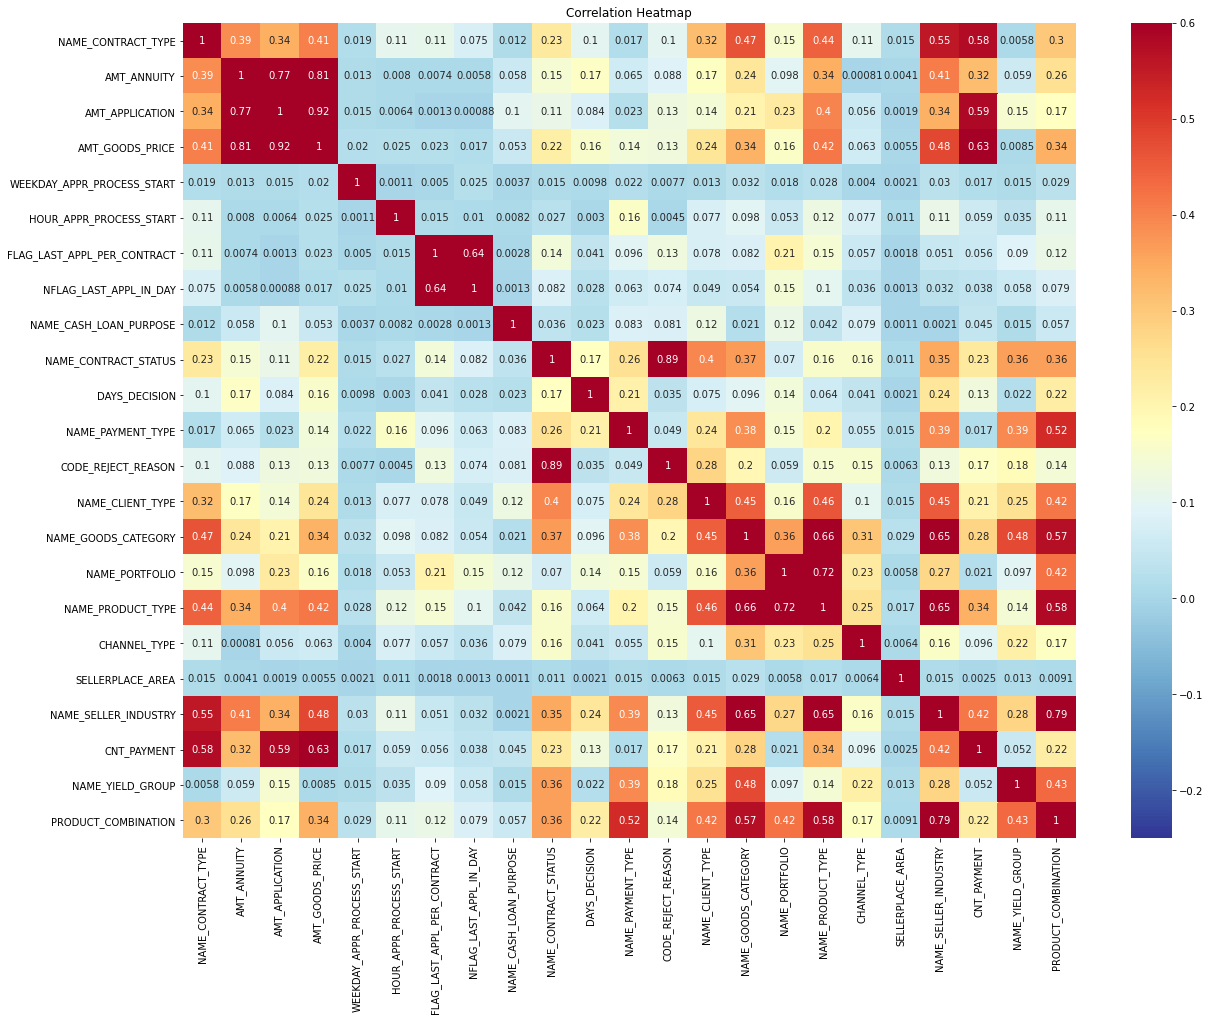

In [59]:
plt.figure(figsize=(20,15))

IP_corr=PA.corr().abs()
sns.heatmap(IP_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

# Preparing data for training the model

In [60]:
#Merging test and Train datas

In [61]:
# merging data based on the train data ( Left)
train_data_use = train_data.merge(CCB,on='SK_ID_CURR', how='left')
train_data_use = train_data.merge(IP,on='SK_ID_CURR', how='left')
train_data_use = train_data.merge(PA,on='SK_ID_CURR', how='left')

In [62]:
test_data_use = test_data.merge(CCB,on='SK_ID_CURR', how='left')
test_data_use = test_data.merge(IP,on='SK_ID_CURR', how='left')
test_data_use = test_data.merge(PA,on='SK_ID_CURR', how='left')

In [63]:
test_data_use.drop(['SK_ID_CURR'], axis=1, inplace=True)
train_data_use.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [64]:
train_data_use=train_data_use.fillna(0)

In [65]:
test_data_use=test_data_use.fillna(0)

In [66]:
# see the alignement all the columns of each data and see remove that ones that are not the same in both 
train_labels=train_data_use['TARGET']
train_data_use, test_data_use = train_data_use.drop(['TARGET'], axis=1).align(test_data_use, join='inner',axis=1)
train_data_use['TARGET']=train_labels

print('Training Features shape: ', train_data_use.shape)
print('Testing Features shape: ', test_data_use.shape)

Training Features shape:  (307511, 90)
Testing Features shape:  (48744, 89)


In [67]:
#### the infinity problem coulb from this

In [68]:
train_data_use['AMT_Credit_%'] = train_data_use['AMT_CREDIT'].astype('float')/train_data_use['AMT_INCOME_TOTAL'].astype('float')
train_data_use['AMT_APPLICATION_%'] = train_data_use['AMT_CREDIT'].astype('float')/train_data_use['AMT_APPLICATION'].astype('float')
train_data_use['AMT_GOODS_PRICE_%'] = train_data_use['AMT_CREDIT'].astype('float')/train_data_use['AMT_GOODS_PRICE'].astype('float')

In [69]:
#train_data_use['AMT_Credit_%']=round(train_data_use['AMT_Credit_%'], 0)
#train_data_use['AMT_APPLICATION_%']=round(train_data_use['AMT_APPLICATION_%'], 0)
#train_data_use['AMT_GOODS_PRICE_%']=round(train_data_use['AMT_GOODS_PRICE_%'], 0)


train_data_use.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_use = train_data_use.fillna(0)

In [70]:
test_data_use['AMT_Credit_%'] = test_data_use['AMT_CREDIT'].astype('float')/test_data_use['AMT_INCOME_TOTAL'].astype('float')
test_data_use['AMT_APPLICATION_%'] = test_data_use['AMT_CREDIT'].astype('float')/test_data_use['AMT_APPLICATION'].astype('float')
test_data_use['AMT_GOODS_PRICE_%'] = test_data_use['AMT_CREDIT'].astype('float')/test_data_use['AMT_GOODS_PRICE'].astype('float')

In [71]:
#test_data_use['AMT_Credit_%']=round(train_data_use['AMT_Credit_%'], 2)
#test_data_use['AMT_APPLICATION_%']=round(train_data_use['AMT_APPLICATION_%'], 2)
#test_data_use['AMT_GOODS_PRICE_%']=round(train_data_use['AMT_GOODS_PRICE_%'], 2)

In [72]:
train_data_use.drop(['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START_y','HOUR_APPR_PROCESS_START_y','CHANNEL_TYPE',\
                    'NAME_SELLER_INDUSTRY','PRODUCT_COMBINATION'], axis=1, inplace=True)
test_data_use.drop(['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START_y','HOUR_APPR_PROCESS_START_y','CHANNEL_TYPE',\
                    'NAME_SELLER_INDUSTRY','PRODUCT_COMBINATION'], axis=1, inplace=True)

In [73]:
train_data_use.shape, test_data_use.shape

((307511, 87), (48744, 86))

# Finding best model to use for this case

In [74]:
# this is the first test of fitting data
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [75]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
# models,predictions = clf.fit(x_train, x_test, y_train, y_test)

In [76]:
#print(models)

# Finting model

In [77]:
# this is the first test of fitting data
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [79]:
# we can use model 
clf = lgb.LGBMClassifier(class_weight='balanced')
clf.fit(x_train, y_train)

LGBMClassifier(class_weight='balanced')

In [80]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.7073
Model accuracy score on train data: 0.7184


<AxesSubplot:>

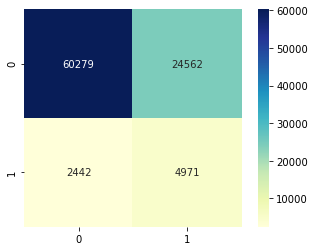

In [81]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [82]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     84841
           1       0.17      0.67      0.27      7413

    accuracy                           0.71     92254
   macro avg       0.56      0.69      0.54     92254
weighted avg       0.90      0.71      0.77     92254



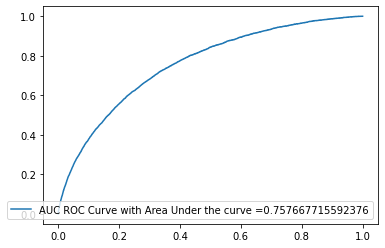

In [83]:
generate_auc_roc_curve(clf, x_test)

# Over Sampling

In [84]:
from imblearn.over_sampling import SMOTE

In [85]:
# give the same amount of data to both target group this will try not to select twice that are  very similary

In [86]:
train_data_use

NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                          0            1             0                1   
1                          0            0             0                0   
2                          1            1             1                1   
3                          0            0             0                1   
4                          0            1             0                1   
...                      ...          ...           ...              ...   
307506                     0            1             0                0   
307507                     0            0             0                1   
307508                     0            0             0                1   
307509                     0            0             0                1   
307510                     0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
0                  0          202500.0    406597.5        24700.5   
1                  0          270000.0   1293502.5        35698.5   
2                  0           67500.0    135000.0         6750.0   
3                  0          135000.0    312682.5        29686.5   
4                  0          121500.0    513000.0        21865.5   
...              ...               ...         ...            ...   
307506             0          157500.0    254700.0        27558.0   
307507             0           72000.0    269550.0        12001.5   
307508             0          153000.0    677664.0        29979.0   
307509             0          171000.0    370107.0        20205.0   
307510             0          157500.0    675000.0        49117.5   

        NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0                     6                 7                    4   
1                     1                 4                    1   
2                     6                 7                    4   
3                     6                 7                    4   
4                     6                 7                    4   
...                 ...               ...                  ...   
307506                6                 7                    4   
307507                6                 3                    4   
307508                6                 7                    1   
307509                6                 1                    4   
307510                6                 1                    1   

        NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                        3                  1                    0.018801   
1                        1                  1                    0.003541   
2                        3                  1                    0.010032   
3                        0                  1                    0.008019   
4                        3                  1                    0.028663   
...                    ...                ...                         ...   
307506                   2                  5                    0.032561   
307507                   5                  1                    0.025164   
307508                   2                  1                    0.005002   
307509                   1                  1                    0.005313   
307510                   1                  1                    0.046220   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0             9461           -637            -3648.0            -2120   
1            16765          -1188            -1186.0             -291   
2            19046           -225            -4260.0            -2531   
3            19005          -3039            -9833.0            -2437   
4            19932          -3038            -4311.0            -3458   
...            ...            ...                ...              ...   
307506        9327           -236    

In [87]:
train_data_use["AMT_Credit_%"].unique()

array([2.00788889, 4.79075   , 2.        , ..., 6.62681818, 4.99544828,
       2.16436842])

In [88]:
train_data_use["AMT_APPLICATION_%"].unique()

array([ 2.27079668,  2.97058813,  5.55967383, ..., 28.04581432,
        3.05072423,  1.86067859])

In [89]:
train_data_use["AMT_GOODS_PRICE_%"].unique()

array([ 2.27079668,  2.97058813,  5.55967383, ..., 28.04581432,
        3.05072423,  1.86067859])

In [90]:
#train_data_use['AMT_Credit_%'] 
#train_data_use['AMT_APPLICATION_%'] 
#train_data_use['AMT_GOODS_PRICE_%'] 

In [91]:
#train_data_use1=train_data_use.drop(['AMT_Credit_%','AMT_APPLICATION_%','AMT_GOODS_PRICE_%'], axis=1, inplace=True)

In [92]:
#train_data_use1

In [93]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [94]:
# over sampler SMOTE 

In [95]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [96]:
Counter(y)

Counter({1: 282686, 0: 282686})

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [98]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [99]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.9528
Model accuracy score on train data: 0.9533


<AxesSubplot:>

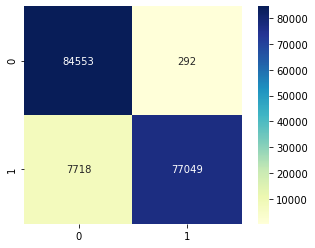

In [100]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [101]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     84845
           1       1.00      0.91      0.95     84767

    accuracy                           0.95    169612
   macro avg       0.96      0.95      0.95    169612
weighted avg       0.96      0.95      0.95    169612



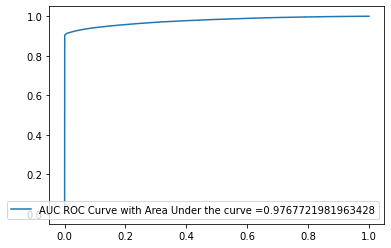

In [102]:
generate_auc_roc_curve(clf, x_test)

In [105]:
# Over sampler ADASYN

In [103]:
from imblearn.over_sampling import ADASYN

In [104]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [106]:
oversample = ADASYN()
x, y = oversample.fit_resample(x, y)

In [107]:
Counter(y)

Counter({1: 288519, 0: 282686})

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [109]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [110]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.9536
Model accuracy score on train data: 0.9535


<AxesSubplot:>

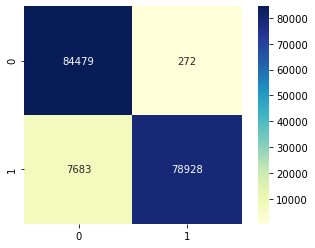

In [111]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [112]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84751
           1       1.00      0.91      0.95     86611

    accuracy                           0.95    171362
   macro avg       0.96      0.95      0.95    171362
weighted avg       0.96      0.95      0.95    171362



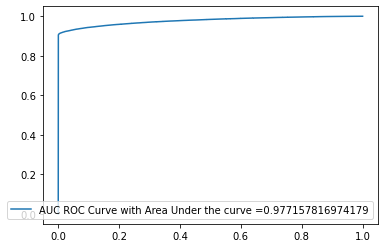

In [113]:
generate_auc_roc_curve(clf, x_test)

In [114]:
# over sampler RandomOverSampler

In [115]:
from imblearn.over_sampling import RandomOverSampler

In [116]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [117]:
oversample = RandomOverSampler()
x, y = oversample.fit_resample(x, y)

In [118]:
Counter(y)

Counter({1: 282686, 0: 282686})

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [120]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [121]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.7125
Model accuracy score on train data: 0.7212


<AxesSubplot:>

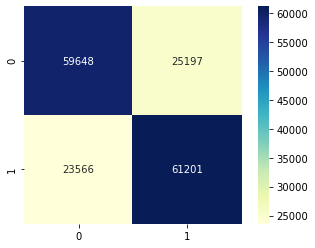

In [122]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [123]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71     84845
           1       0.71      0.72      0.72     84767

    accuracy                           0.71    169612
   macro avg       0.71      0.71      0.71    169612
weighted avg       0.71      0.71      0.71    169612



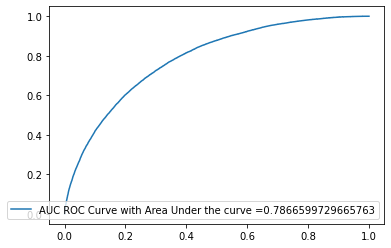

In [124]:
generate_auc_roc_curve(clf, x_test)

# Under Sampling

In [125]:
from imblearn.under_sampling import RandomUnderSampler

In [126]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [127]:
# under sampler RandomUnderSampler

In [128]:
undersample = RandomUnderSampler()
x, y = undersample.fit_resample(x, y)

In [129]:
Counter(y)

Counter({0: 24825, 1: 24825})

In [130]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [131]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [132]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.6957
Model accuracy score on train data: 0.7496


<AxesSubplot:>

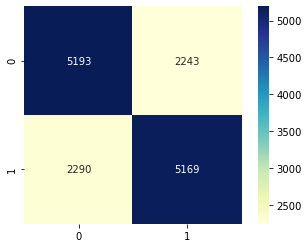

In [133]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [134]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70      7436
           1       0.70      0.69      0.70      7459

    accuracy                           0.70     14895
   macro avg       0.70      0.70      0.70     14895
weighted avg       0.70      0.70      0.70     14895



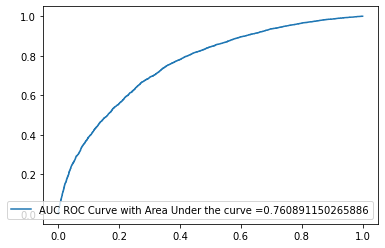

In [135]:
generate_auc_roc_curve(clf, x_test)

In [136]:
from imblearn.under_sampling import TomekLinks

In [137]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [138]:
# under sampler TomekLinks

In [139]:
undersample = TomekLinks()
x, y = undersample.fit_resample(x, y)

In [140]:
Counter(y)

Counter({1: 24825, 0: 271324})

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [142]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [143]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.9161
Model accuracy score on train data: 0.9181


<AxesSubplot:>

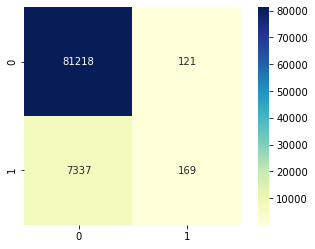

In [144]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [145]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     81339
           1       0.58      0.02      0.04      7506

    accuracy                           0.92     88845
   macro avg       0.75      0.51      0.50     88845
weighted avg       0.89      0.92      0.88     88845



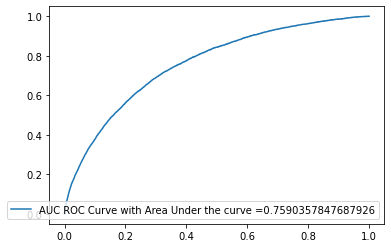

In [146]:
generate_auc_roc_curve(clf, x_test)

In [147]:
# undersample Near MISS

In [148]:
from imblearn.under_sampling import NearMiss

In [149]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [150]:
undersample = NearMiss()
x, y = undersample.fit_resample(x, y)

In [151]:
Counter(y)

Counter({0: 24825, 1: 24825})

In [152]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [153]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [154]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.8563
Model accuracy score on train data: 0.8836


<AxesSubplot:>

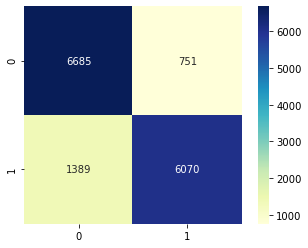

In [155]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [156]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      7436
           1       0.89      0.81      0.85      7459

    accuracy                           0.86     14895
   macro avg       0.86      0.86      0.86     14895
weighted avg       0.86      0.86      0.86     14895



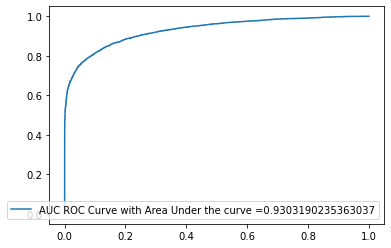

In [157]:
generate_auc_roc_curve(clf, x_test)

# Feature Importance

In [158]:
# we will see wish columns affect the target most

In [159]:
x = train_data_use.drop(['TARGET'],axis=1).copy()
y = train_data_use['TARGET'].copy()

In [160]:
undersample = NearMiss() ##### change algoritn here for the best result 
x, y = undersample.fit_resample(x, y)

In [161]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [162]:
clf = lgb.LGBMClassifier()   # i used the classifer of the best model 
clf.fit(x_train, y_train)

LGBMClassifier()

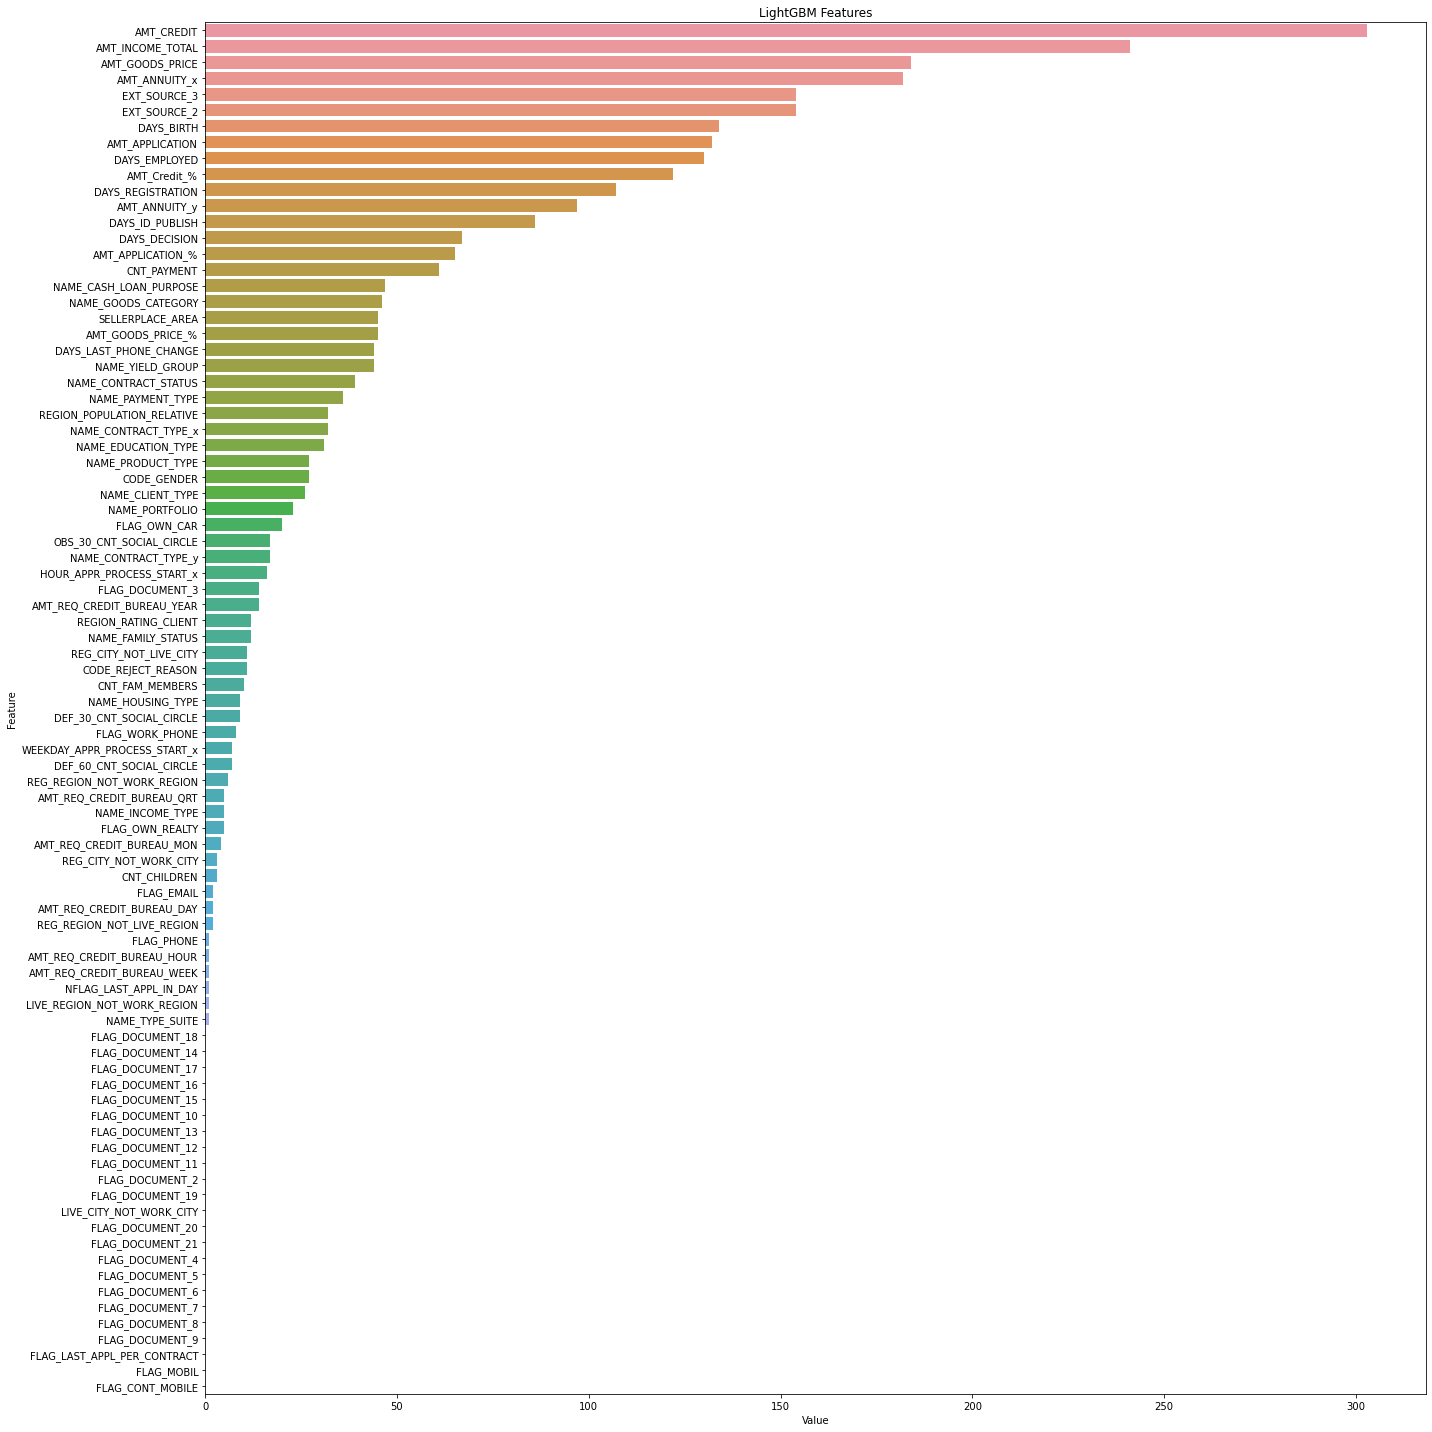

In [163]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [164]:
# removing columns that has  0 effect on the "target" value
toRemove=[feat[1] for feat in sorted(zip(clf.feature_importances_,x.columns)) if feat[0]==0]

In [165]:
toRemove

['FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'FLAG_MOBIL',
 'LIVE_CITY_NOT_WORK_CITY']

In [166]:
train_data_clean=train_data_use.drop(toRemove, axis=1)
test_data_clean=test_data_use.drop(toRemove, axis=1)

In [167]:
train_data_clean

NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                          0            1             0                1   
1                          0            0             0                0   
2                          1            1             1                1   
3                          0            0             0                1   
4                          0            1             0                1   
...                      ...          ...           ...              ...   
307506                     0            1             0                0   
307507                     0            0             0                1   
307508                     0            0             0                1   
307509                     0            0             0                1   
307510                     0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
0                  0          202500.0    406597.5        24700.5   
1                  0          270000.0   1293502.5        35698.5   
2                  0           67500.0    135000.0         6750.0   
3                  0          135000.0    312682.5        29686.5   
4                  0          121500.0    513000.0        21865.5   
...              ...               ...         ...            ...   
307506             0          157500.0    254700.0        27558.0   
307507             0           72000.0    269550.0        12001.5   
307508             0          153000.0    677664.0        29979.0   
307509             0          171000.0    370107.0        20205.0   
307510             0          157500.0    675000.0        49117.5   

        NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0                     6                 7                    4   
1                     1                 4                    1   
2                     6                 7                    4   
3                     6                 7                    4   
4                     6                 7                    4   
...                 ...               ...                  ...   
307506                6                 7                    4   
307507                6                 3                    4   
307508                6                 7                    1   
307509                6                 1                    4   
307510                6                 1                    1   

        NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                        3                  1                    0.018801   
1                        1                  1                    0.003541   
2                        3                  1                    0.010032   
3                        0                  1                    0.008019   
4                        3                  1                    0.028663   
...                    ...                ...                         ...   
307506                   2                  5                    0.032561   
307507                   5                  1                    0.025164   
307508                   2                  1                    0.005002   
307509                   1                  1                    0.005313   
307510                   1                  1                    0.046220   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0             9461           -637            -3648.0            -2120   
1            16765          -1188            -1186.0             -291   
2            19046           -225            -4260.0            -2531   
3            19005          -3039            -9833.0            -2437   
4            19932          -3038            -4311.0            -3458   
...            ...            ...                ...              ...   
307506        9327           -236    

In [168]:
# we will run a new test to see if we can get the target value
x = train_data_clean.drop(['TARGET'],axis=1).copy()
y = train_data_clean['TARGET'].copy()

In [169]:
# we will use the same model we found the best model on 
oversample =  ADASYN()
x, y = oversample.fit_resample(x, y)

In [170]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)

In [171]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

LGBMClassifier()

In [172]:
y_pred_test=clf.predict(x_test)
accuracy=accuracy_score(y_pred_test, y_test)
print('Model accuracy score on test data: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

y_pred_train=clf.predict(x_train)
accuracy=accuracy_score(y_pred_train, y_train)
print('Model accuracy score on train data: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model accuracy score on test data: 0.8569
Model accuracy score on train data: 0.8832


<AxesSubplot:>

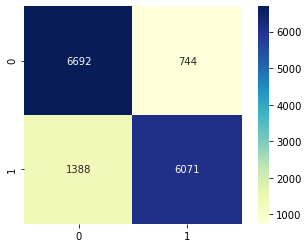

In [173]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [174]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      7436
           1       0.89      0.81      0.85      7459

    accuracy                           0.86     14895
   macro avg       0.86      0.86      0.86     14895
weighted avg       0.86      0.86      0.86     14895



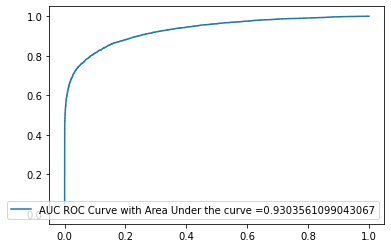

In [175]:
generate_auc_roc_curve(clf, x_test)

In [176]:
# we creating a new " target" is the % and "class" if it's default or not 

# .drop(['TARGET','Class','SK_ID_CURR'], axis=1)
test_data_clean['TARGET']=clf.predict_proba(test_data_clean)[:,1]
test_data_clean['Class']=clf.predict(test_data_clean.drop(['TARGET'], axis=1))

In [177]:
x = train_data_clean.drop(['TARGET'],axis=1).copy()

In [178]:
res_train=pd.DataFrame(columns=['SK_ID_CURR', 'TARGET', 'Class'])

In [179]:
train_data_clean['TARGET']=clf.predict_proba(x)[:,1]
train_data_clean['Class']=train_data['TARGET']
# train_data_clean['Class']=clf.predict(x)

In [180]:
train_data_clean['SK_ID_CURR']=train_data['SK_ID_CURR']
test_data_clean['SK_ID_CURR']=test_data['SK_ID_CURR']

In [181]:
result = pd.concat([train_data_clean, test_data_clean], axis=0)
result=result.sort_values(by='SK_ID_CURR', ascending=True)

In [182]:
result

NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                          0            0             0                1   
0                          0            1             0                1   
1                          0            0             0                0   
2                          1            1             1                1   
1                          0            1             0                1   
...                      ...          ...           ...              ...   
307506                     0            1             0                0   
307507                     0            0             0                1   
307508                     0            0             0                1   
307509                     0            0             0                1   
307510                     0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
0                  0          135000.0    568800.0        20560.5   
0                  0          202500.0    406597.5        24700.5   
1                  0          270000.0   1293502.5        35698.5   
2                  0           67500.0    135000.0         6750.0   
1                  0           99000.0    222768.0        17370.0   
...              ...               ...         ...            ...   
307506             0          157500.0    254700.0        27558.0   
307507             0           72000.0    269550.0        12001.5   
307508             0          153000.0    677664.0        29979.0   
307509             0          171000.0    370107.0        20205.0   
307510             0          157500.0    675000.0        49117.5   

        NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0                     6                 6                    1   
0                     6                 7                    4   
1                     1                 4                    1   
2                     6                 7                    4   
1                     6                 6                    4   
...                 ...               ...                  ...   
307506                6                 7                    4   
307507                6                 3                    4   
307508                6                 7                    1   
307509                6                 1                    4   
307510                6                 1                    1   

        NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                        1                  1                    0.018850   
0                        3                  1                    0.018801   
1                        1                  1                    0.003541   
2                        3                  1                    0.010032   
1                        1                  1                    0.035792   
...                    ...                ...                         ...   
307506                   2                  5                    0.032561   
307507                   5                  1                    0.025164   
307508                   2                  1                    0.005002   
307509                   1                  1                    0.005313   
307510                   1                  1                    0.046220   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0           -19241          -2329            -5170.0             -812   
0             9461           -637            -3648.0            -2120   
1            16765          -1188            -1186.0             -291   
2            19046           -225            -4260.0            -2531   
1           -18064          -4469            -9118.0            -1623   
...            ...            ...                ...              ...   
307506        9327           -236    

In [183]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=result.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

KeyError: 'Value'

<Figure size 1440x720 with 0 Axes>

In [184]:
result.to_csv('result.csv', index=False)

In [185]:
##### this is the connected part of the APP

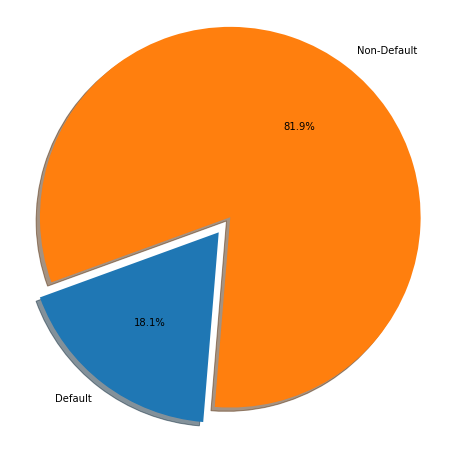

In [186]:
plt.figure(figsize=(8, 8))

labels=['Default', 'Non-Default']
sizes=[result[result['Class']==1]['Class'].count(), result[result['Class']==0]['Class'].count()]

plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', 
        shadow=True,
        startangle=200,
        explode = [0, 0.1])

plt.axis('equal')
plt.savefig("PieChart.png")
plt.show()

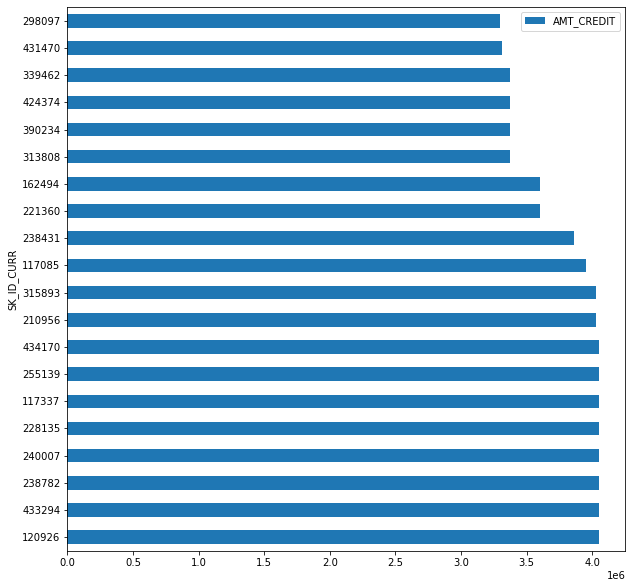

In [187]:
amtCredit=result.sort_values(by='AMT_CREDIT', ascending=False)[['SK_ID_CURR', 'AMT_CREDIT']]
amtCredit.set_index('SK_ID_CURR')[:20].plot.barh(figsize=(10, 10))
plt.savefig("CreditAmount.png")

In [188]:
[feat[1] for feat in sorted(zip(clf.feature_importances_,x.columns)) if feat[0]>=100]

['AMT_Credit_%',
 'AMT_APPLICATION',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT']

In [189]:
focus={'AMT_Credit_%': "the average between the loan and the income"
       'AMT_APPLICATION':'For how much credit did client ask on the previous application',
'DAYS_EMPLOYED':'How many days before the application the person started current employment',
'DAYS_BIRTH':"Client's age in days at the time of application",
'AMT_GOODS_PRICE':'Goods price of good that client asked for (if applicable) on the previous application',
'AMT_ANNUITY_x':'Annuity of previous application',
'AMT_INCOME_TOTAL':'Income of the client',
'AMT_CREDIT':' Credit amount of the loan'}

In [190]:
result['DAYS_BIRTH']

0        -19241
0          9461
1         16765
2         19046
1        -18064
          ...  
307506     9327
307507    20775
307508    14966
307509    11961
307510    16856
Name: DAYS_BIRTH, Length: 356255, dtype: int64

In [191]:
id=394688

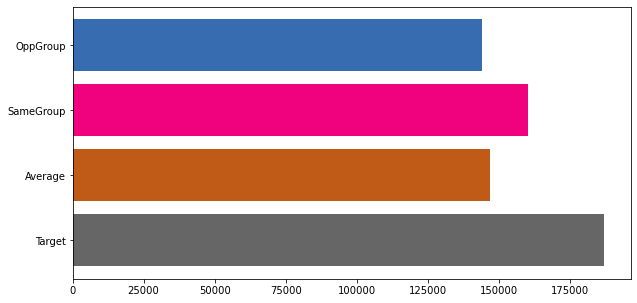

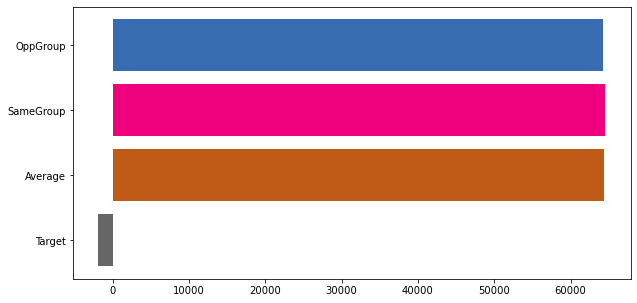

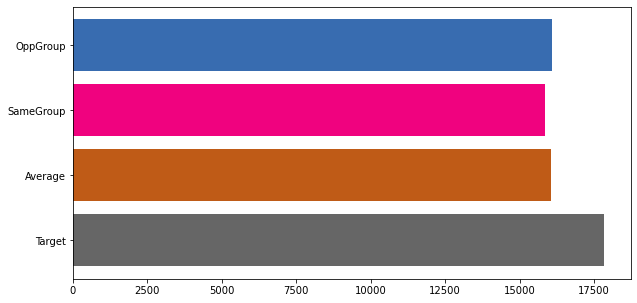

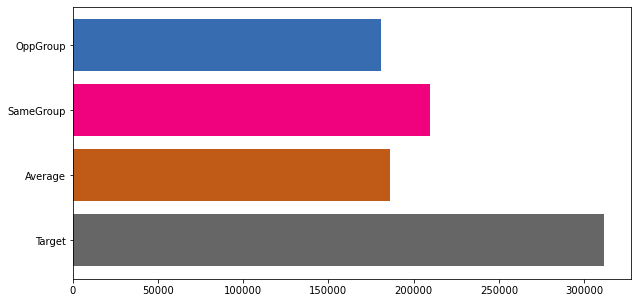

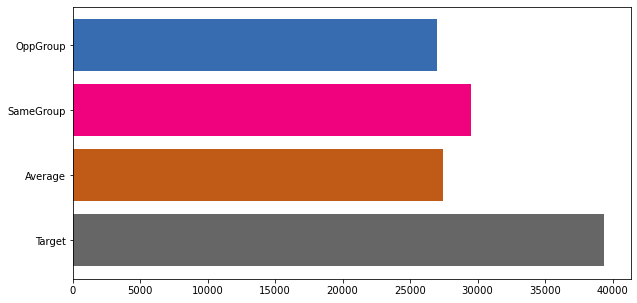

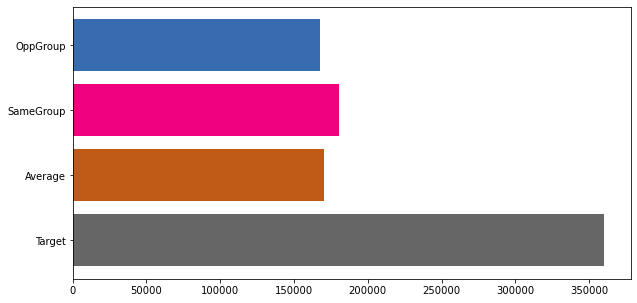

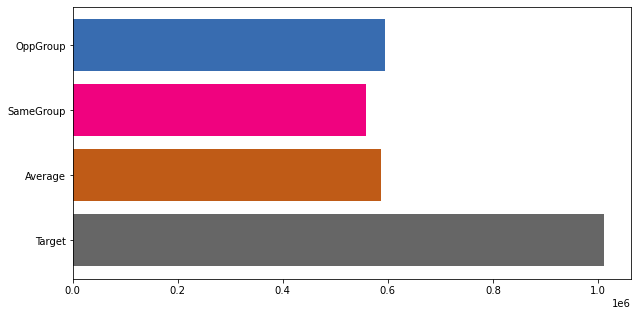

In [192]:
result['DAYS_BIRTH']=abs(result['DAYS_BIRTH'])
client=result[result['SK_ID_CURR']==id]
sameClass=result[result['Class']==int(client['Class'].values[0])]
if int(client['Class'])==1:
    oppClass=result[result['Class']==0]
else:
    oppClass=result[result['Class']==1]

for key, val in focus.items():
    temp=pd.DataFrame(columns=['Target','Average','SameGroup','OppGroup'])
    temp['Target']=client[key]
    temp['Average']=np.average(result[key].values)
    temp['SameGroup']=np.average(sameClass[key].values)
    temp['OppGroup']=np.average(oppClass[key].values)
    temp=temp.T
    plt.figure(figsize=(10, 5))
    plt.barh(temp.index, temp[temp.columns[0]], color=plt.cm.Accent_r(np.arange(len(temp))))
    plt.savefig("./static/images/specific/"+key+".png")
    plt.show()

In [193]:
result

NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                          0            0             0                1   
0                          0            1             0                1   
1                          0            0             0                0   
2                          1            1             1                1   
1                          0            1             0                1   
...                      ...          ...           ...              ...   
307506                     0            1             0                0   
307507                     0            0             0                1   
307508                     0            0             0                1   
307509                     0            0             0                1   
307510                     0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  \
0                  0          135000.0    568800.0        20560.5   
0                  0          202500.0    406597.5        24700.5   
1                  0          270000.0   1293502.5        35698.5   
2                  0           67500.0    135000.0         6750.0   
1                  0           99000.0    222768.0        17370.0   
...              ...               ...         ...            ...   
307506             0          157500.0    254700.0        27558.0   
307507             0           72000.0    269550.0        12001.5   
307508             0          153000.0    677664.0        29979.0   
307509             0          171000.0    370107.0        20205.0   
307510             0          157500.0    675000.0        49117.5   

        NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0                     6                 6                    1   
0                     6                 7                    4   
1                     1                 4                    1   
2                     6                 7                    4   
1                     6                 6                    4   
...                 ...               ...                  ...   
307506                6                 7                    4   
307507                6                 3                    4   
307508                6                 7                    1   
307509                6                 1                    4   
307510                6                 1                    1   

        NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                        1                  1                    0.018850   
0                        3                  1                    0.018801   
1                        1                  1                    0.003541   
2                        3                  1                    0.010032   
1                        1                  1                    0.035792   
...                    ...                ...                         ...   
307506                   2                  5                    0.032561   
307507                   5                  1                    0.025164   
307508                   2                  1                    0.005002   
307509                   1                  1                    0.005313   
307510                   1                  1                    0.046220   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0            19241          -2329            -5170.0             -812   
0             9461           -637            -3648.0            -2120   
1            16765          -1188            -1186.0             -291   
2            19046           -225            -4260.0            -2531   
1            18064          -4469            -9118.0            -1623   
...            ...            ...                ...              ...   
307506        9327           -236    

In [194]:

#has to be removed because:

#ORGANIZATION_TYPE :  this shows where he words
#WEEKDAY_APPR_PROCESS_START_y: IT shows the day of process 
# HOUR_APPR_PROCESS_START_y : it show the time it was starting working on the file

# CHANNEL_TYPE : Through which channel we acquired the client on the previous application
# NAME_SELLER_INDUSTRY : : The industry of the seller
# PRODUCT_COMBINATION



# this need to be done as a one hot encoder

#NAME_CASH_LOAN_PURPOSE: because this shows what is the reason he needs the loan 
# NAME_PAYMENT_TYPE because this shows the payement type he used
#CODE_REJECT_REASON because it shows why the previous application was refused
# NAME_CLIENT_TYPE because it says if he was a new , old , or repeater for financial request
# NAME_GOODS_CATEGORY because it shows what goods he did apply on the first time
#NAME_PORTFOLIO because it shows the previous application for CASH, POS, CAR, 
# NAME_YIELD_GROUP : Grouped interest rate into small medium and high of the previous application

# Feature Importance

In [ ]:
#pipeline for commun function 95% clean to overwright the RAW 
# 
# best model classifer and hyer parameter on only over sampling 
# create a new CSV file that has the % of the 